In [4]:
import os
import json
import random
import copy
import math

import numpy as np
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
import pandas as pd

from sklearn.metrics.pairwise import haversine_distances,euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from scipy import spatial
from shapely import geometry
from fuzzywuzzy import fuzz

# set matpltolib style
plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

In [5]:
def get_center(line):
    bbox = np.array(line['boundingBox'],dtype=np.int32).reshape((4,2))
    return np.mean(bbox,axis=0)

    
# Compare the two geolocation arrays for the same line and take best        
def take_best(line):
    geo1 = line['geolocation']
    geo2 = line['geolocation2']
    empty1 = len(geo1) == 0
    empty2 = len(geo2) == 0
    text1,text2 = line['text'].split('|')
    if empty1 and empty2:
        return None
    elif empty1:
        line['geolocation'] = geo2
        line['text'] = text2
    elif empty2:
        line['geolocation'] = geo1
        line['text'] = text1
    else:
        if geo1[0][1] >= geo2[0][1]:
            line['geolocation'] = geo1
            line['text'] = text1
        else:
            line['geolocation'] = geo2
            line['text'] = text2
            
    del line['geolocation2']
    return line


 
def remove_duplicate_geolocations(geo):
    placename_types = {'country','political','locality','administrative_area','sublocality','sublocality_level_1','geography'}
    road_types = {'street','road','route'}
    
    for g_ in geo:
        g = g_[0]
        if 'type' in g:
            typ = g['type']
            types = typ.lower().split(',')
            found=False
            for t in types:
                if t in placename_types:
                    g['type'] = 'locality'
                    break
                elif t in road_types:
                    g['type'] = 'street'
                    break
    
    res = []
    found_names = {}
    # lat,lng
    found_coords = np.array([[0,0]],dtype=np.float32)
    delta_street = 0.01
    delta_locality = 0.1
    for g_ in geo:
        g = g_[0]
        if 'type' in g:
            typ = g['type']
            name = g['name'].lower()
            lat = g['lat']
            lng = g['lng']
            c1 = np.array([lat,lng],dtype=np.float32)
            
            if name in found_names:
                found_types = found_names[name]
                # check if it is close
                if typ in found_types:
                   
                    dlat =np.min(np.abs(c1[0]-found_coords[:,0]))
                    dlng =np.min(np.abs(c1[1]-found_coords[:,1]))
                    
                    
                    delta = delta_locality if typ == 'locality' else delta_street
                    
                    if dlat > delta and dlng > delta:
                        res.append(g_)
                        found_coords = np.append(found_coords,[c1],axis=0)
                    
                else:
                    found_types.add(typ)
                    res.append(g_)
                    found_coords = np.append(found_coords,[c1],axis=0)
                    
            else:
                found_names[name] = {typ}
                res.append(g_)
                found_coords = np.append(found_coords,[c1],axis=0)
       
    return res


def haversine(lat1,lng1,lat2,lng2):

    lng1, lat1, lng2, lat2 = map(math.radians, [lng1, lat1, lng2, lat2])
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    return (2 * 6371 * math.asin(math.sqrt(a)))*1000


def filter_geo_inside(geolocations,lat_min,lng_min,lat_max,lng_max):
    """
    Returns the geolocations which lie inside the supplied coordinates
    """
    res =[]
    for g in geolocations:
        lat = g[0]['lat']
        lng = g[0]['lng']
        if lat_min < lat < lat_max and lng_min < lng < lng_max:
            res.append(g)
    return res

def take_longest_match(text, geolocations):
    """
    Filter out duplicate matches
    e.g. if text = zandbergstr and matches are zandberg and zandbergstraat (both have 100 partial string similarity)
    it will take zandbergstraat as that contains the longest substring
    If both contain the same substring, both are returned
    """
    #all have same score in arrary
    if len(geolocations) < 2:
        return geolocations
    else:
        idx_longest = -1
        l_text = len(text)
        # check differences in string length, take least diff if unique
        d_lengths = [len(g[0]['name'])-l_text for g in geolocations]
        abs_lengths = np.abs(d_lengths)
        sorted_lengths = sorted(abs_lengths)
        # if 2 or more best ones have same length diff
        if sorted_lengths[0] == sorted_lengths[1]:
            min_ = np.min([d if d >= 0 else l_text for d in d_lengths ])
            return [geolocations[i] for i in range(len(d_lengths)) if d_lengths[i] == min_]
        else:
            min_idx = np.argmin(abs_lengths)
            return [geolocations[min_idx]]
        

def mean_dist2(bounds,bounds_label):
    """
    Bounds label is already shape (4,2)
    We need to calculate for each corner point closest point to polygon, take it and remove for next comparison
    """
    # Ensure points are ordered correctly!
    x1,x2 = sorted(bounds[::2])
    y1,y2 = sorted(bounds[1::2])
    
    bbox1 = np.array([[y1,x1],[y2,x1],[y2,x2],[y1,x2]])
    bbox2 = sort_points(bounds_label[:,::-1])
    
    sum_d = 0
    max_d = 0
    
    # For each point of bounds, find closest polygon label point
    # Then take the minimum as best, remove from array and do again
    points_remaining_bounds = [0,1,2,3]
    points_remaining_label = [0,1,2,3]
    
    while len(points_remaining_bounds) > 0:
        min_dist = np.inf
        current = []
        for i in points_remaining_bounds:
            # calculate dist to each point
            for j in points_remaining_label:
                dist = haversine(*bbox1[i],*bbox2[j])
                
                if dist < min_dist:
                    min_dist = dist
                    current = [i,j]
           
        sum_d += min_dist
        if min_dist > max_d:
            max_d = min_dist
        
        points_remaining_bounds.remove(current[0])
        points_remaining_label.remove(current[1])
        
    return sum_d/4,max_d


def sort_points(pts):
    # Sort correctly
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = spatial.distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    pts = np.array([tl, tr, br, bl], dtype="float32")
    
    return pts
    

In [58]:
def center_dist_scale(bounds,bounds_label):
    # Ensure points are ordered correctly!
    x1,x2 = sorted(bounds[::2])
    y1,y2 = sorted(bounds[1::2])
    
    c1 = [(y1+y2)/2,(x1+x2)/2]
    c2 = np.mean(bounds_label,axis=0)[::-1]
    center_dist = haversine(*c1,*c2)
    p_min = np.min(bounds_label,axis=0)[::-1]
    p_max = np.max(bounds_label,axis=0)[::-1]
    scale = center_dist/haversine(*p_max,*p_min)
    
    return center_dist,scale


def remove_bad_matches(geo, thresh=75):
    """
    Remove all geolocations with score lower than thresh
    """
    return [g for g in geo if g[1] >= thresh]


def angle(point):
    """
    Returns the signed angle [-180, 180] of the 2D point (x,y)
    """
    return np.degrees(np.math.atan2(point[1] ,point[0]))

    

# Source: https://stackoverflow.com/a/7869457/5582470
def angle_diff(p1,p2):
    """
    Return ABSOLUTE difference in degrees between 2 angles [0,180]
    """
    a1 = angle(p1)
    a2 = angle(p2)
    
    d = a1 - a2
    if d > 180:
        d -= 360
    elif d < -180:
        d += 360
    return abs(d)


def check_bounds(bounds,arr_geo,arr_xy):
    """
    Remove furthest point from bounds, if any point is outside of them
    """
    lat_min,lng_min,lat_max,lng_max = bounds
    
    lngs = arr_geo[:,0].copy()
    lats = arr_geo[:,1].copy()
    
    
    d_min_lng = lngs - lng_min
    d_max_lng = lng_max - lngs
    
    d_min_lat = lats - lat_min
    d_max_lat = lat_max - lats
    
    # Find largest error index
    arr = [d_min_lng,d_max_lng,d_min_lat,d_max_lat]
    
    min_val = 0
    min_idx = -1
    for i,a in enumerate(arr):
        m = np.min(a)
        if m <= min_val:
            min_idx = i
            min_val = m
    
    if min_idx == -1:
        return arr_geo,arr_xy
    else:
        
        array = arr[min_idx]
        id_to_remove = np.argmin(array)
        #print('Removed id:',id_to_remove,'min val:',min_val)
        return np.delete(arr_geo,id_to_remove,axis=0),np.delete(arr_xy,id_to_remove,axis=0)
    
    

def geolocate(lines,img_shape,filter_common=True,verbose=0,label_coords=None,figure_fname=None):
    thresh = 70
    n_matches_max = 5
    h,w = img_shape[:2]
    xy_bounds = np.array([[0,h],[w,h],[w,0],[0,0]])
    xy_polygon = geometry.Polygon(xy_bounds)
    
    # Filter duplicate matches from multiple geocoders
    total_before = 0
    total_after = 0
    
    arr_geo = []
    sample_weights = []
    for current_line_idx,l in enumerate(lines):
        geo = l['geolocation']
        for g in geo:
            g = g[0]
            arr_geo.append([g['lng'],g['lat']])
            sample_weights.append(1/len(geo))
            
    arr_geo = np.array(arr_geo)
    sample_weights = np.array(sample_weights)
    # List of bounds,center for each part of the algo
    
    step_bounds = []
    
    biggest_cluster = None
    # STEP1 Cluster the geolocations and take those inside the largest cluster
    x = StandardScaler().fit_transform(arr_geo)
    db = DBSCAN(eps=.2, min_samples=5).fit(x)
    labels = db.labels_
    
    if np.max(labels) > -1:
        unique, counts = np.unique([l for l in labels if l > -1], return_counts=True)
        biggest_cluster = unique[np.argmax(counts)]
    
    if biggest_cluster is not None:
        mask = labels == biggest_cluster
        points_inside = arr_geo[mask]
        lng_min1 = np.min(points_inside[:,0])
        lng_max1 = np.max(points_inside[:,0])
        lat_min1 = np.min(points_inside[:,1])
        lat_max1 = np.max(points_inside[:,1])
        bounds1 = (lat_min1,lng_min1,lat_max1,lng_max1)
        #bounds1 = np.array([[lng_min1,lat_max1],[lng_max1,lat_max1],[lng_max1,lat_min1],[lng_min1,lat_min1]])
        center1 = np.mean(points_inside, axis=0)
        step_bounds.append([bounds1,center1])
    else:
        print('-----------------')
        print('BIGGEST CLUSTER NONE')
        print('-------------------')
        # CLuster bounds

    if verbose:
        plt.figure(figsize=(12,12))
        plt.title('Initial geocoder matches',fontsize=20)
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1],s=4)
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation',linewidth=8)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude',fontsize=18)
        plt.axis('tight')
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.xlim(0,10)
        plt.ylim(45,55)
        #plt.savefig('initial_matches.png',bbox_inches='tight')
        plt.show()
        
    
    
    sample_weights = []
    arr_geo = []
    arr_xy = []
    lines_possible = []
    lines_discarded = []
    sim_scores = []
    line_ids = []
    # Remove duplicates 
    # Check if there are at least 20 lines with
    # less or equal than 5 geolocation matches
    # if there are 20 or more, use only those matches
    # else use the first 5 from all lines?
    for current_line_idx,l in enumerate(lines):
        geo = l['geolocation']
        geo = remove_duplicate_geolocations(geo)
        geo = remove_bad_matches(geo, thresh=thresh)
        l['geolocation'] = geo
        
        if  0 < len(geo) <= n_matches_max:
            
            discard = False
            ids_to_remove = set()
            max_ = geo[0][1]
            if max_ < thresh or len(geo) > n_matches_max:
                lines_discarded.append(copy.deepcopy(l))
                continue
            n_matches = 0
           
            for g in geo:
                # Sorted from high score to low
                if g[1] < thresh:
                    break

                lat = g[0]['lat']
                lng = g[0]['lng']
                arr_geo.append([lng, lat])
                sim_scores.append(5*(g[1]-thresh)/100)
                arr_xy.append(get_center(l))
                line_ids.append(current_line_idx)    
                   
                n_matches += 1
                
            lines_possible.append(copy.deepcopy(l))
            if n_matches > 0:
                weights = [1/n_matches] * n_matches
                sample_weights.extend(weights)
    
    # If we find less than 20 text labels to use,
    # we include the first 5 matches for all text labels
    # THIS IS NEVER EXECUTED for TOP50Raster
    if len(lines_possible) < 20:
        start_line_idx = len(lines_possible)
        
        for idx,l in enumerate(lines_discarded):
            current_line_idx = start_line_idx + idx
            if len(l['geolocation'])==0:
                continue
            
            l2 = copy.deepcopy(l)
            geo = l2['geolocation'][:5]
            l2['geolocation'] = geo
            n_matches = 0
            
            for g in geo:
                # Sorted from high score to low
                if g[1] < thresh:
                    break

                lat = g[0]['lat']
                lng = g[0]['lng']
                arr_geo.append([lng, lat])
                sim_scores.append(5*(g[1]-thresh)/100)
                n_matches += 1
                arr_xy.append(get_center(l))
                line_ids.append(current_line_idx)
                
            lines_possible.append(l2)
            if n_matches > 0:
                weights = [1/n_matches] * n_matches
                sample_weights.extend(weights)
            
    arr_xy = np.array(arr_xy, dtype=np.float32)    
    arr_geo = np.array(arr_geo, dtype=np.float32)
    
    if verbose:
        plt.figure(figsize=(10, 10))
        plt.title('Arr geo after prefilter')
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1])
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')
        plt.show()
    # First filter out the outliers
    # n_points need to lie within max_dist to keep the point
    arr_radians = np.radians(arr_geo)
    dists = haversine_distances(arr_radians) * 6371
    
    max_dist = 100
    n_max = 5
    points_filtered = []
    xy_filtered = []
    min_dists = []
    median_dists = []
    sample_weights_filtered = []
    line_ids_filtered = []
    geo_ids_filtered = []
    len_before = len(arr_geo)
    print()
    line_ids = np.array(line_ids)
    for i,d in enumerate(dists):
        # remove 0 distance with self 
        d_sorted = np.sort(d)[1:]
        # Ignore duplicate coordinates
        while d_sorted[0] == 0:
            d_sorted = d_sorted[1:]
        
        
        min_d = d_sorted[0]
        med_d = np.median(d_sorted)
        if min_d < max_dist and d_sorted[n_max-1] < max_dist:
            points_filtered.append(arr_geo[i])
            min_dists.append(min_d)
            #median_dists.append(med_d)
            
            xy_filtered.append(arr_xy[i])
            #sample_weights_filtered.append(sample_weights[i]+sim_scores[i])
            sample_weights_filtered.append(sample_weights[i])
            line_ids_filtered.append(line_ids[i])
            # To know the index of the correct geolocation of the line
            # Get first index of occurence of line_idx
            first_index = np.argmax(line_ids==line_ids[i])
            # The difference gives the geo idx
            geo_ids_filtered.append(i-first_index)
            
    print('Prefilter filtered out:',len_before - len(points_filtered))
    arr_xy = np.array(xy_filtered,dtype=np.float32)
    # y reversed
    arr_xy[:,1] = h - arr_xy[:,1]
    arr_geo = np.array(points_filtered, dtype=np.float32)
    line_ids = np.array(line_ids_filtered)
    geo_ids = np.array(geo_ids_filtered)
    
    sample_weights = np.array(sample_weights_filtered, dtype=np.float32)
    # STEP1 Cluster the geolocations and take those inside the largest cluster
    x = StandardScaler().fit_transform(arr_geo)
    db = DBSCAN(eps=.2, min_samples=5).fit(x,sample_weight=sample_weights)
    labels = db.labels_
    biggest_cluster = None

    if np.max(labels) == -1:
        print('NO CLUSTERS FOUND, RETURNING NONE')

        if verbose:
            plt.figure(figsize=(10, 10))
            plt.title('Arr geo after prefilter, no clusters')
            plt.scatter(arr_geo[:, 0], arr_geo[:, 1])
            if label_coords is not None:
                label_poly = geometry.Polygon(label_coords)
                plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')
            plt.show()

        return None
    else:
        unique, counts = np.unique([l for l in labels if l > -1], return_counts=True)
        biggest_cluster = unique[np.argmax(counts)]
        

    if verbose:
        label_colors = ['C'+str(l+1) if l < 9 else 'C0' for l in labels]
        
        plt.figure(figsize=(12, 12))
        plt.title('Result after filtering and clustering',fontsize=20)
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1], c=label_colors)
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation',linewidth=4)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude',fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        #plt.savefig('cluster.png',bbox_inches='tight')
        plt.show()
       
         
    if biggest_cluster is not None:
        mask = labels == biggest_cluster
        points_inside = arr_geo[mask]
        xy_inside = arr_xy[mask]
        line_ids_inside = line_ids[mask]
        geo_ids_inside = geo_ids[mask]
        
        lng_min2 = np.min(points_inside[:,0])
        lng_max2 = np.max(points_inside[:,0])
        lat_min2 = np.min(points_inside[:,1])
        lat_max2 = np.max(points_inside[:,1])
        bounds2 = (lat_min2,lng_min2,lat_max2,lng_max2)
       
        center2 = np.mean(points_inside, axis=0)
        step_bounds.append([bounds2,center2])
        
        if verbose:
            plt.figure(figsize=(12, 12))
            plt.title('Initial Region of Interest',fontsize=20)
            plt.scatter(points_inside[:, 0], points_inside[:, 1])
            if label_coords is not None:
                label_poly = geometry.Polygon(label_coords)
                plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')
            plt.xlabel('Longitude', fontsize=18)
            plt.ylabel('Latitude',fontsize=18)
            plt.tick_params(axis='both', which='minor', labelsize=18)
            plt.axis('tight')
            #plt.savefig('inside.png',bbox_inches='tight')
            plt.show()
            
    
    # CLuster bounds
    lng1 = np.min(points_inside[:,0])
    lng2 = np.max(points_inside[:,0])
    lat1 = np.min(points_inside[:,1])
    lat2 = np.max(points_inside[:,1])
    
     
    temp_xy = np.array(xy_inside, dtype=np.float64)
    temp_geo = np.array(points_inside, dtype=np.float64)
    
    # Difference in angles
    # For each point: calculate angle of line to all other points
    # Then compare their abs difference between geo coords and xy-coords
    diff_xy = np.zeros((len(temp_xy),len(temp_xy)),dtype=np.float64)
    diff_geo = np.zeros((len(temp_geo),len(temp_geo)),dtype=np.float64)
    
    for i in range(len(temp_xy)):
        for j in range(len(temp_xy)):
            diff_xy[i,j] = (angle(temp_xy[j]-temp_xy[i]))
            diff_geo[i,j] = (angle(temp_geo[j]-temp_geo[i]))
        
   
    res = diff_xy-diff_geo
    # Clean up angles 
    res[res > 180] -= 360
    res[res < -180] += 360
    # Take abs error only, dont care about direction of error
    angle_error = np.abs(res)
    
    arr_radians = np.radians(temp_geo)
    dists_geo = haversine_distances(arr_radians) * 6371
    dists_xy = euclidean_distances(temp_xy)
    
    all_ratios = []
    all_angles = []
    for i in range(len(dists_geo)):
        
        d_geo = dists_geo[i]
        d_xy = dists_xy[i]
        
        ratio = d_geo.mean()/d_xy.mean()
        all_ratios.append(ratio)
        # Take average error of angle for point i
        all_angles.append(angle_error[i].mean())
        
    all_ratios = np.array(all_ratios, dtype=np.float64)
    all_angles = np.array(all_angles, dtype=np.float64)
    
    median = np.median(all_ratios)
    d_median = np.abs(all_ratios - median)
    d_indices = np.argsort(d_median)
    take = .5
    n_take = int(round(len(d_median)*take))
    indices = d_indices[:n_take]
    
    a_indices = np.argsort(all_angles)
    
    n_take = int(round(len(a_indices)*take))
    a_indices = a_indices[:n_take]
    
    
    # TO SHOW ERROR DISTRIBUTIONS
    if verbose:
        df = pd.DataFrame()
        df['ratios'] = all_ratios
        df['angles'] = all_angles
        df['ratio_err'] = d_median

        x1,x2 = all_ratios[indices].min(),all_ratios[indices].max()
        sns.displot(data=df,x='ratios',bins=35,stat='probability')
        plt.xlabel('Distance ratio', fontsize=18)
        plt.axis('tight')
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.title('Histogram of distance ratios',fontsize=20)
        plt.savefig('error_ratios.png',bbox_inches='tight')
        plt.show()
        
        
        x1,x2 = all_angles[a_indices].min(),all_angles[a_indices].max()
        sns.displot(data=df,x='angles',bins=35,stat='probability')
        angle_take = np.sort(all_angles)[n_take-1]
        plt.xlabel('Mean relative angle error', fontsize=18)
        plt.ylabel('Relative amount',fontsize=18)
        plt.axis('tight')
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.title('Histogram of angle errors',fontsize=20)
        #plt.savefig('error_angles.png',bbox_inches='tight')
        plt.show()
        print()
    

    res_indices = np.intersect1d(indices, a_indices, assume_unique=True)
    
    arr_geo = temp_geo[res_indices].copy()
    arr_xy = temp_xy[res_indices].copy()
    
    print('After error metric filtering')
    if verbose:
        print('Total points inside:',len(arr_geo),'Total points:',len(temp_geo))

        plt.figure(figsize=(20, 10))
        plt.subplot(1,2,1)
        plt.title('Geocoder coordinates',fontsize=20)
        plt.scatter(temp_geo[:,0],temp_geo[:,1],color='C0',s=18)

        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1],color='C3',s=50)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude',fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        
        plt.subplot(1,2,2)
        plt.title('Text label coordinates',fontsize=20)
        plt.scatter(temp_xy[:,0],temp_xy[:,1],s=18)
        plt.plot(*xy_polygon.exterior.xy, color='C2')
        plt.scatter(arr_xy[:,0],arr_xy[:,1],color='C3',s=50)
        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y',fontsize=18)
        plt.xlim(-500,w+500)
        plt.ylim(-500,h+500)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        #plt.savefig('refining.png',bbox_inches='tight')
        plt.show()
    
    
    
    # y back to normal
    arr_xy[:,1] = h - arr_xy[:,1]
    
    # Calc factor based on average lat/lng over x/y dist with centers
    factors = []
    for i in range(len(arr_geo)):
        coord_geo = arr_geo[i]
        coord_xy = arr_xy[i]
        d_geo = coord_geo - arr_geo
        d_xy = coord_xy - arr_xy
        f = d_geo.mean(axis=0)/d_xy.mean(axis=0)
        #f[1] = -f[1]
        factors.append(f)
    factors = np.array(factors)    
    
    # x should be pos. correlated, y should be neg. correlated
    mask1 = (factors[:,0] > 0) & (factors[:,1] < 0)
    
    points_inside = arr_geo[mask1]
    xy_inside = arr_xy[mask1]
    
    lng_min3 = np.min(points_inside[:,0])
    lng_max3 = np.max(points_inside[:,0])
    lat_min3 = np.min(points_inside[:,1])
    lat_max3 = np.max(points_inside[:,1])
    bounds3 = (lat_min3,lng_min3,lat_max3,lng_max3)

    center3 = np.mean(points_inside, axis=0)
    step_bounds.append([bounds3,center3])
    
    center_geo = np.mean(points_inside,axis=0)
    center_xy = np.mean(xy_inside, axis=0)
    d_geo = np.abs(center_geo - points_inside)
    d_xy = np.abs(center_xy - xy_inside)  
    factor = d_geo/d_xy
    factor = np.median(factor,axis=0)
    factor[1] = -factor[1]
   
    # Warp the map bounds
    top_left = center_geo - (factor * center_xy)
    bot_right = center_geo - (factor * (center_xy - np.array([w,h])))
    
    
    lng_min = top_left[0]
    lng_max = bot_right[0]
    lat_min = bot_right[1]
    lat_max = top_left[1]
    
    bounds = (lat_min,lng_min,lat_max,lng_max)
    bounds_ = np.array([[lng_min,lat_max],[lng_max,lat_max],[lng_max,lat_min],[lng_min,lat_min]])
    bounds_poly = geometry.Polygon(bounds_)
    print('After warping map bounds:')
    if verbose:
       
        plt.figure(figsize=(20, 10))
        plt.subplot(1,2,1)
        plt.title('Geocoder coordinates',fontsize=20)
        plt.scatter(temp_geo[:,0],temp_geo[:,1],color='C0',s=18)
        plt.plot(*bounds_poly.exterior.xy,color='C3',label='Predicted geolocation')
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')
        plt.scatter(points_inside[:, 0], points_inside[:, 1],color='C3',s=50)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude',fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        #plt.xlim(lng1,lng2)
        #plt.ylim(lat1,lat2)
        

        plt.subplot(1,2,2)
        plt.title('Text label coordinates',fontsize=20)
        # y reversed for plot
        arr_xy[:,1] = h - arr_xy[:,1]
        xy_inside[:,1] = h-xy_inside[:,1]
        
        plt.scatter(temp_xy[:,0],temp_xy[:,1],s=18)
        plt.plot(*xy_polygon.exterior.xy, color='C2')
        plt.scatter(xy_inside[:,0],xy_inside[:,1],color='C3',s=50)
        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y',fontsize=18)
        plt.xlim(-500,w+500)
        plt.ylim(-500,h+500)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        plt.savefig('refining.png',bbox_inches='tight')
        plt.show()
        

        # y back to normal
        arr_xy[:,1] = h - arr_xy[:,1]
        xy_inside[:,1] = h-xy_inside[:,1]
    
    # Check if points are outside bounds, if they are, remove them and warp again
    filtered,filtered_xy = check_bounds(bounds,points_inside,xy_inside)
    while len(filtered) < len(points_inside):
        
        points_inside = filtered.copy()
        xy_inside = filtered_xy.copy()
        
        # Redo warping with new points
        center_geo = np.mean(points_inside,axis=0)
        center_xy = np.mean(xy_inside, axis=0)
        d_geo = np.abs(center_geo - points_inside)
        d_xy = np.abs(center_xy - xy_inside)  
        factor = d_geo/d_xy
        factor = np.median(factor,axis=0)
        factor[1] = -factor[1]
        # Warp the map bounds
        top_left = center_geo - (factor * center_xy)
        bot_right = center_geo - (factor * (center_xy - np.array([w,h])))
        lng_min = top_left[0]
        lng_max = bot_right[0]
        lat_min = bot_right[1]
        lat_max = top_left[1]
        bounds = (lat_min,lng_min,lat_max,lng_max)
        filtered,filtered_xy = check_bounds(bounds,points_inside,xy_inside)
    
    
    bounds_ = np.array([[lng_min,lat_max],[lng_max,lat_max],[lng_max,lat_min],[lng_min,lat_min]])
    bounds_poly = geometry.Polygon(bounds_)
    # y reversed again
    arr_xy[:,1] = h - arr_xy[:,1] 
    xy_inside[:,1] = h-xy_inside[:,1]
    
    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1,2,1)
        plt.title('Final prediction', fontsize=20)
        #plt.scatter(arr_geo[:,0],arr_geo[:,1],color='C0',s=18)

        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy,color='C2',label='Real geolocation')

        plt.plot(*bounds_poly.exterior.xy,color='C3',label='Predicted geolocation')
        plt.scatter(points_inside[:, 0], points_inside[:, 1],color='C3',s=50)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude',fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.legend(loc='upper center', ncol=2)
        plt.axis('tight')
        
        #plt.xlim(lng1,lng2)
        #plt.ylim(lat1,lat2)

        plt.subplot(1,2,2)
        plt.title('Text label coordinates',fontsize=20)
        #plt.scatter(arr_xy[:,0],arr_xy[:,1],s=18)
        plt.plot(*xy_polygon.exterior.xy, color='C2')
        plt.scatter(xy_inside[:,0],xy_inside[:,1],color='C3',s=50)
        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y',fontsize=18)
        plt.xlim(-500,w+500)
        plt.ylim(-500,h+500)
        plt.axis('tight')
        
        plt.savefig('final.png',bbox_inches='tight')
        plt.show()
        
    
    bounds = (lat_min,lng_min,lat_max,lng_max)
    center5 = np.array([(lng_min+lng_max)/2, (lat_min+lat_max)/2])
    step_bounds.append([bounds,center5])
     # Filter the matches to lie inside the cluster and take the best match (1 text should return 1 match)
    for l in lines_possible:
        geo = l['geolocation']
        geo = filter_geo_inside(geo, lat_min, lng_min, lat_max, lng_max)
        geo = take_longest_match(l['text'], geo)
        l['geolocation'] = geo
    
   
    
   
    for l in lines_discarded:
        geo = l['geolocation']
        geo = filter_geo_inside(geo, lat_min, lng_min, lat_max, lng_max)
        geo = take_longest_match(l['text'], geo)
        l['geolocation'] = geo
    
    return lines_possible,lines_discarded,bounds,step_bounds
    

# Geolocate the maps


Current file: TOP50raster-31O-2018.jpg
Total geolocations: 26108 geolocations per line: 38.91


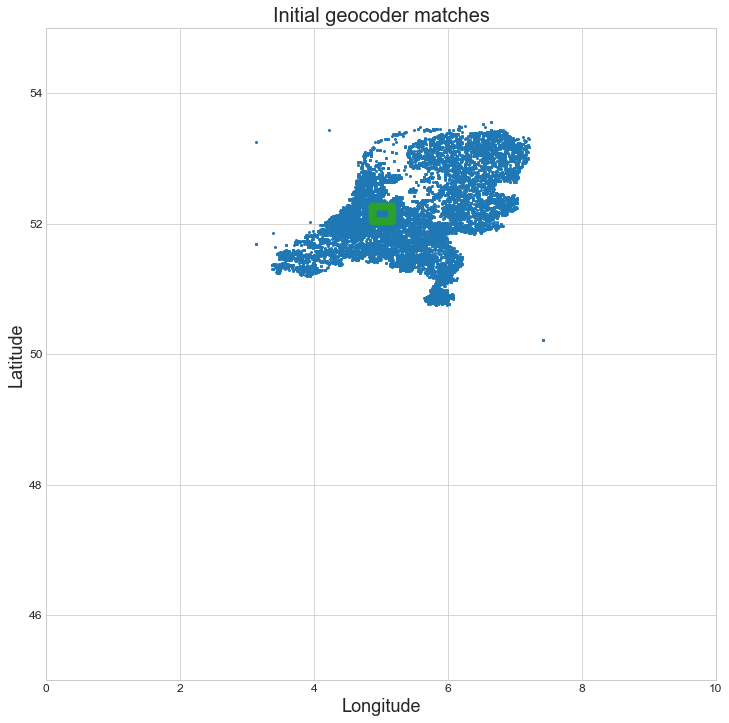

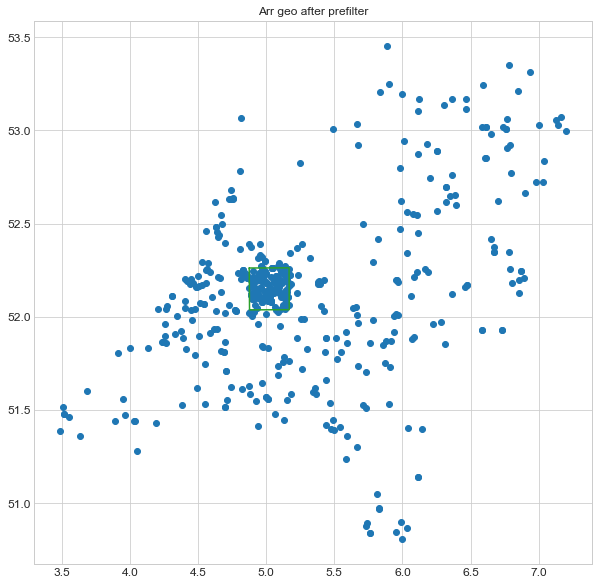


Prefilter filtered out: 0


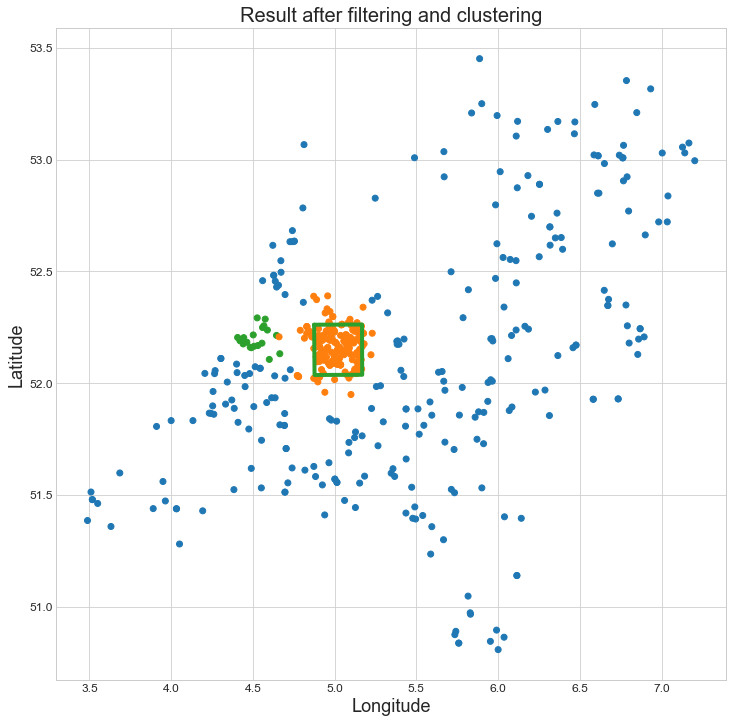

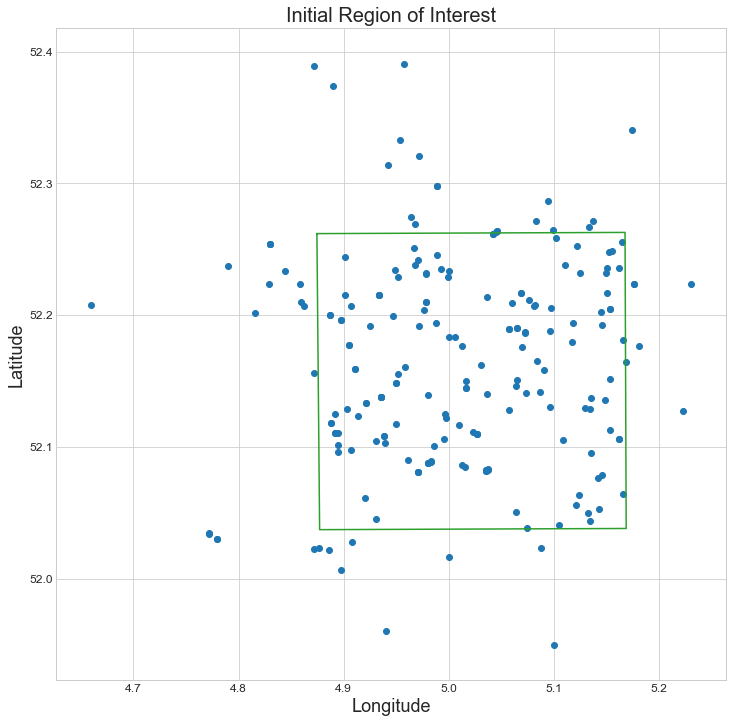

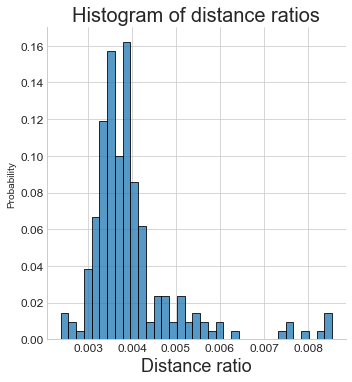

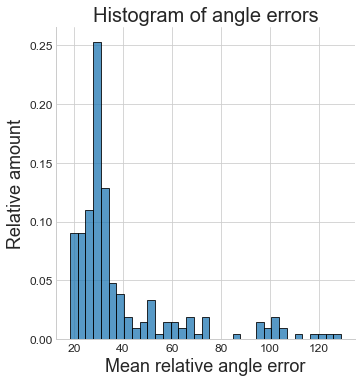


After error metric filtering
Total points inside: 61 Total points: 210


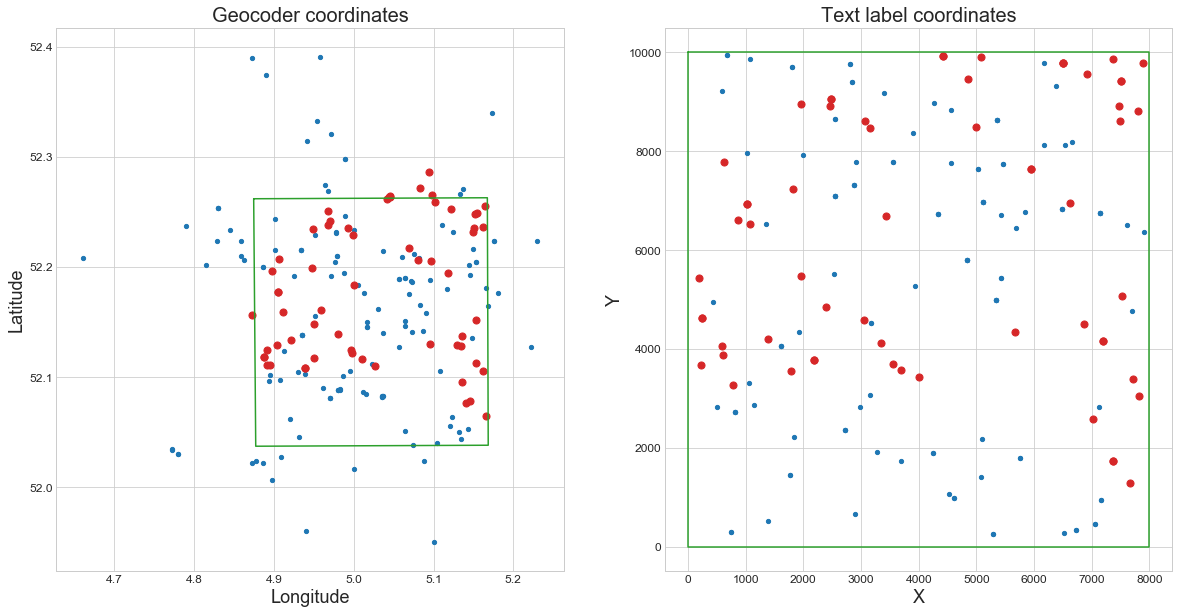

After warping map bounds:


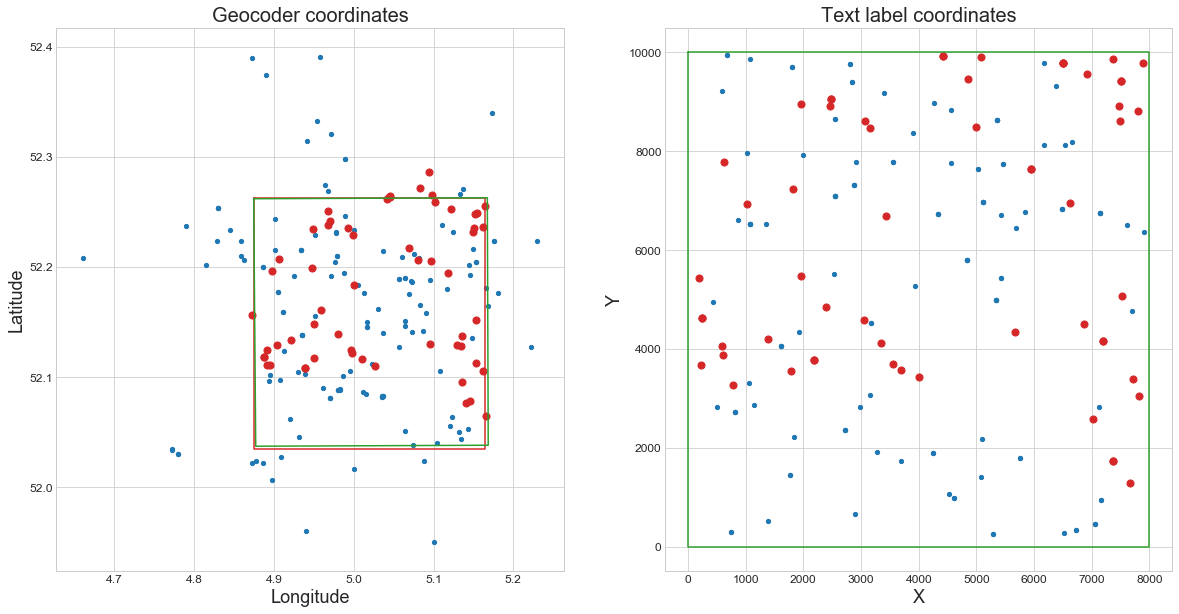

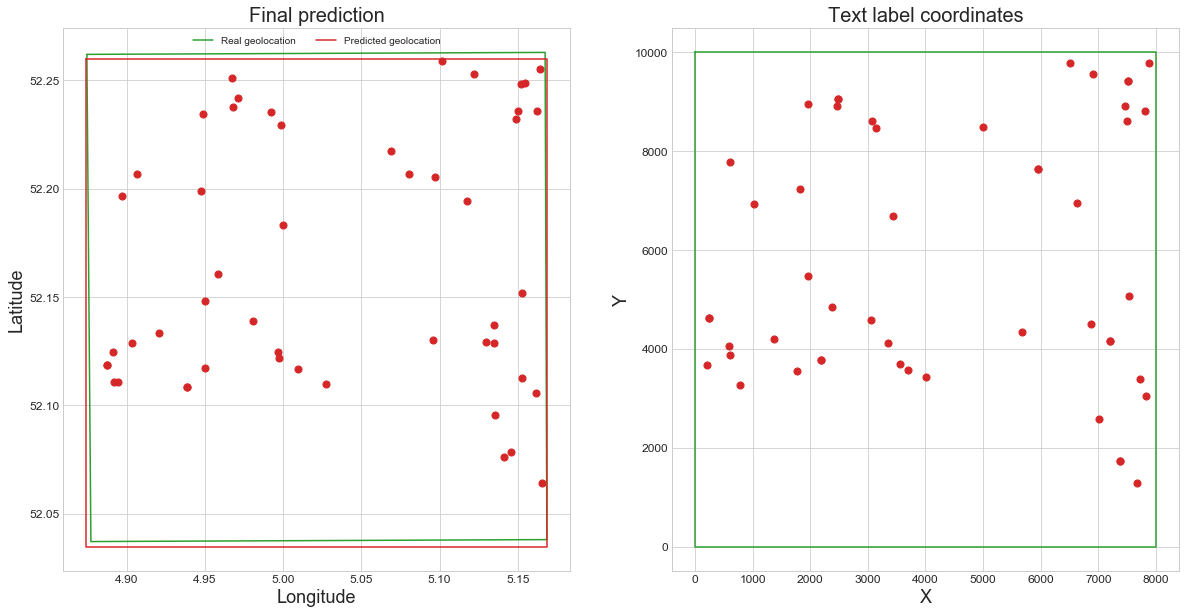

Max dist of bounds: 359 m
Mean dist of bounds: 310 m
Center dist: 289 scale: 0.009


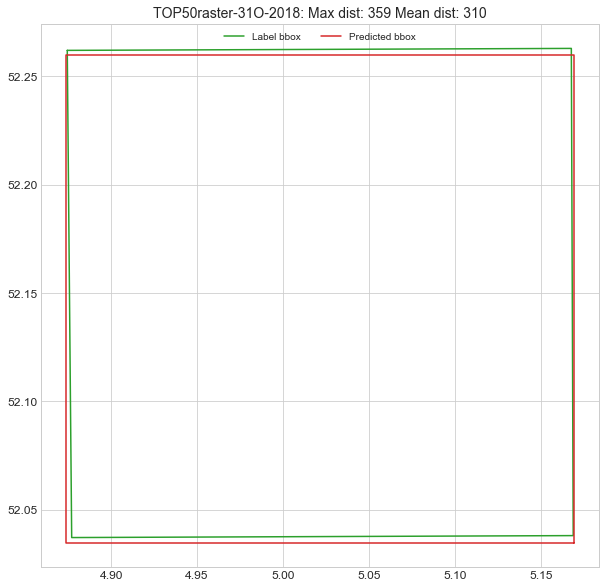


Current file: TOP50raster-32O-2018.jpg
Total geolocations: 23604 geolocations per line: 40.63


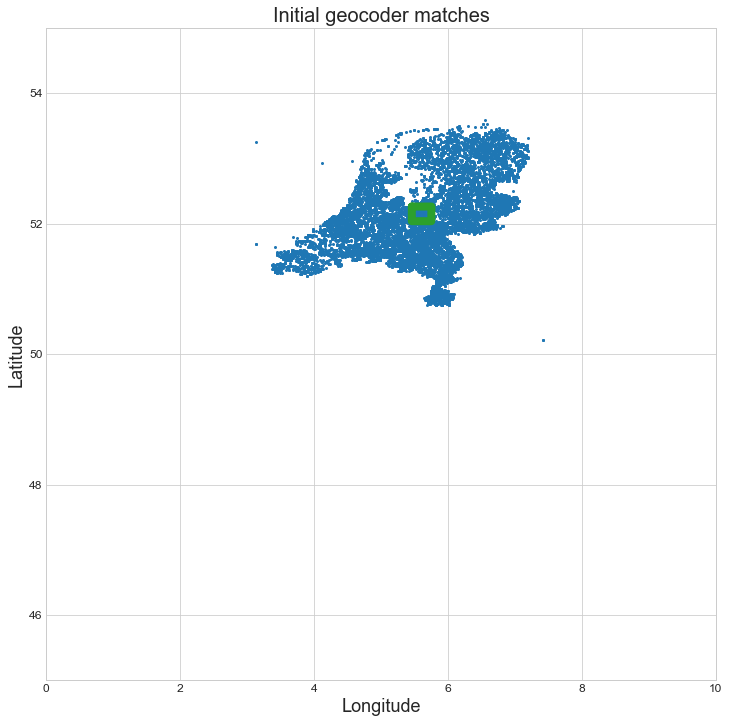

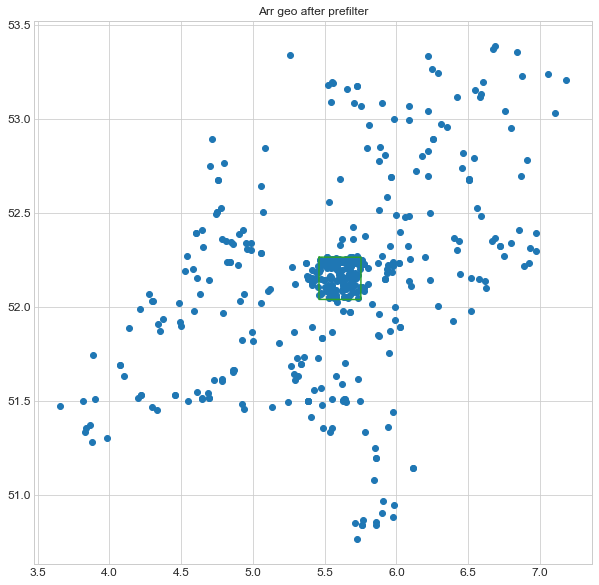


Prefilter filtered out: 0


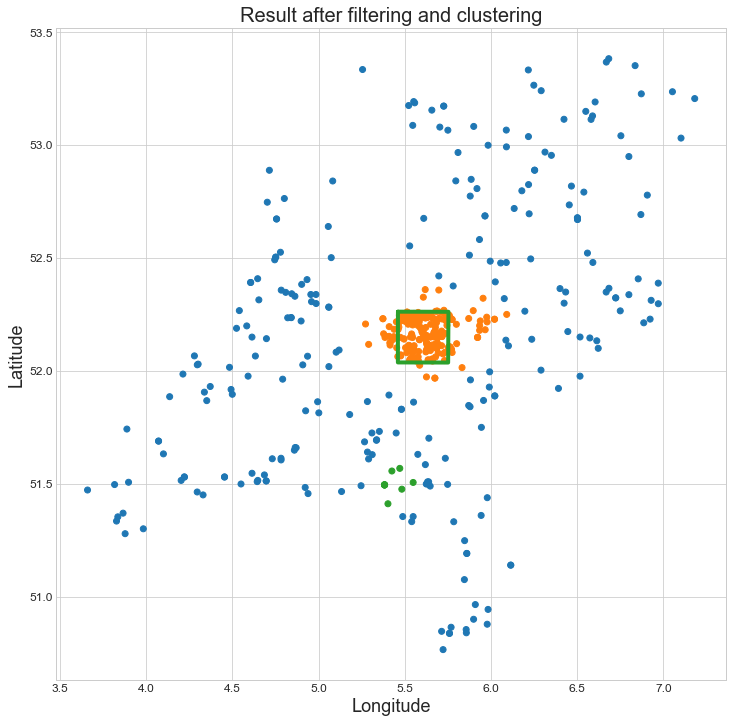

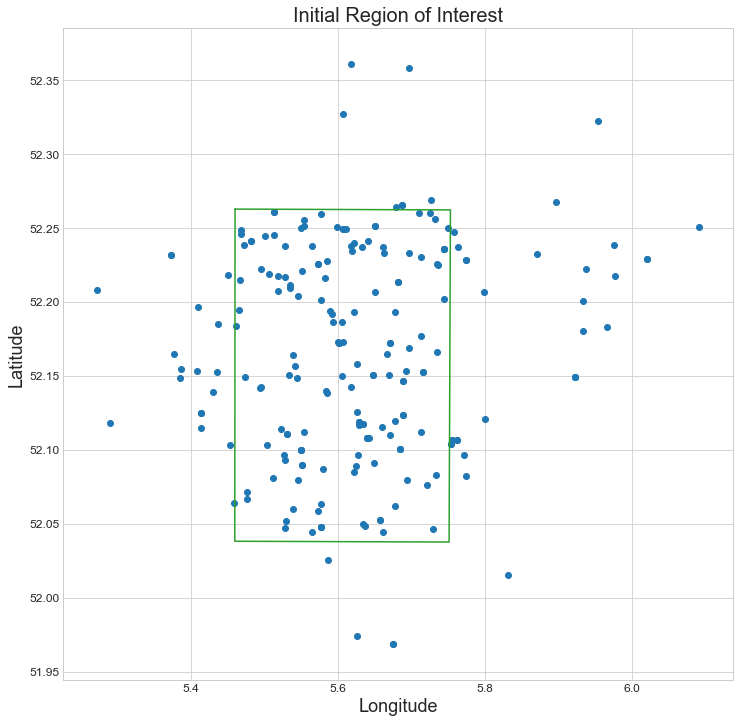

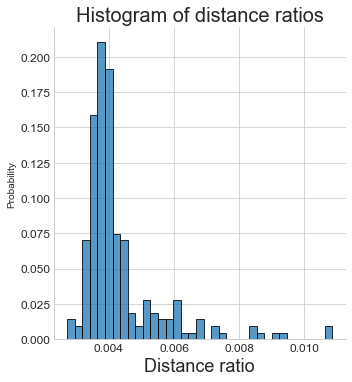

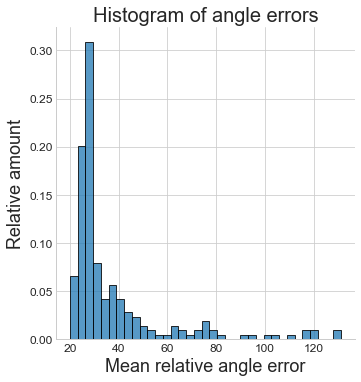


After error metric filtering
Total points inside: 66 Total points: 214


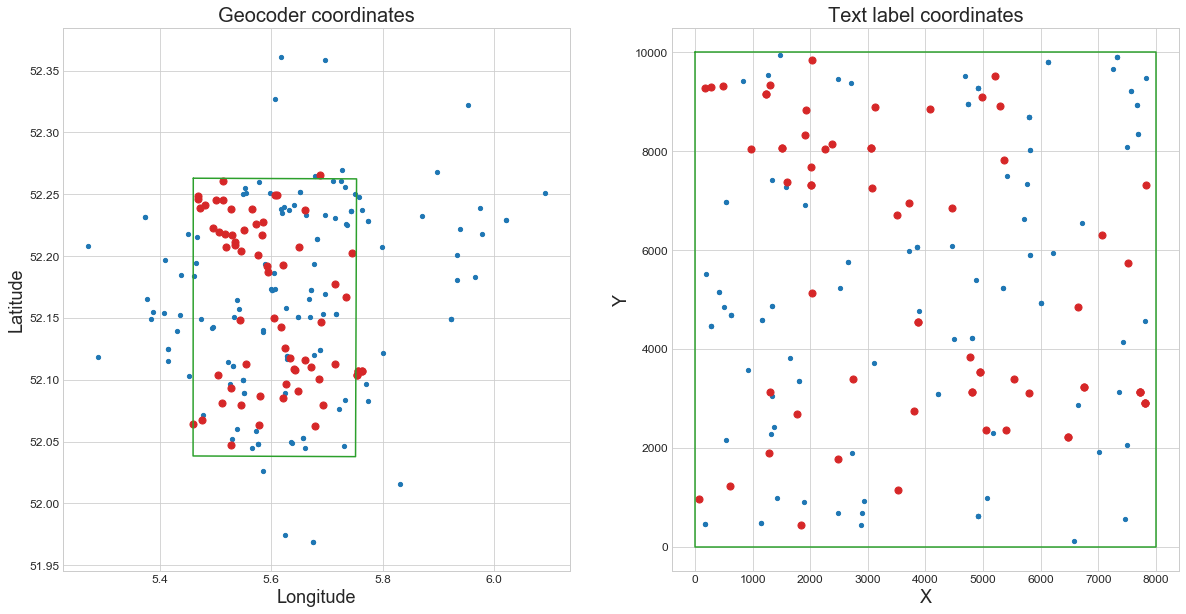

After warping map bounds:


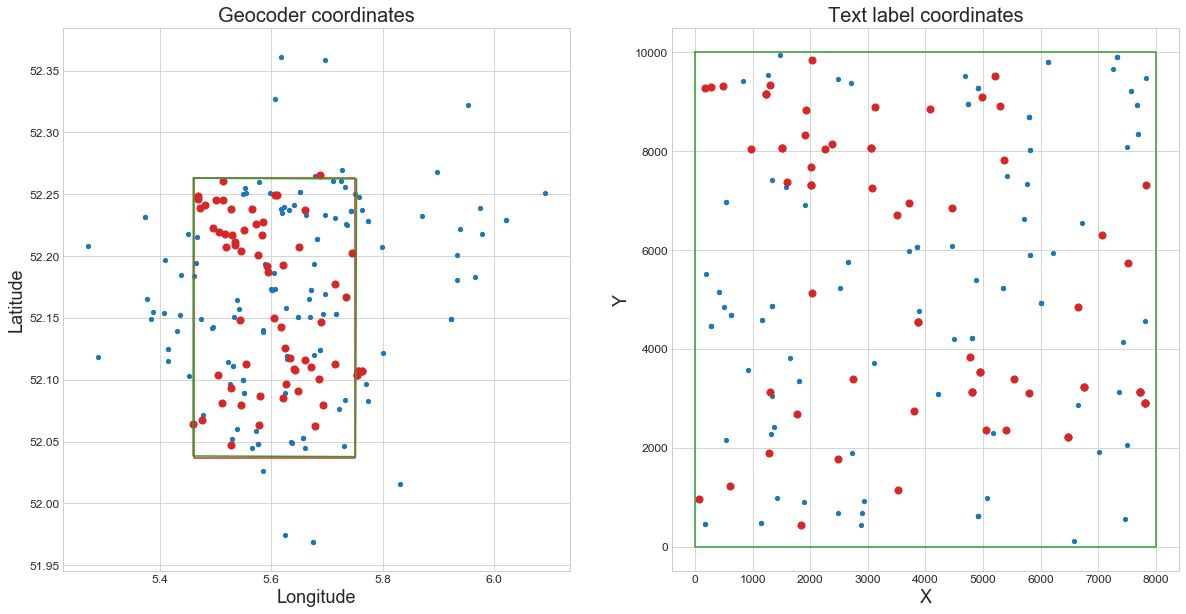

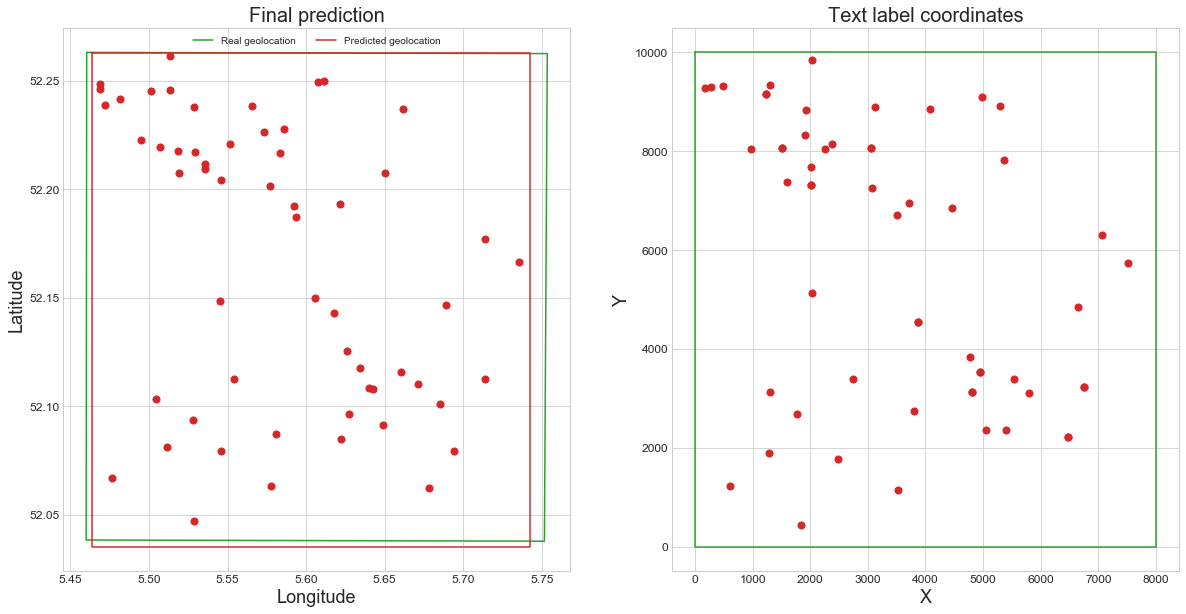

Max dist of bounds: 756 m
Mean dist of bounds: 522 m
Center dist: 269 scale: 0.0084


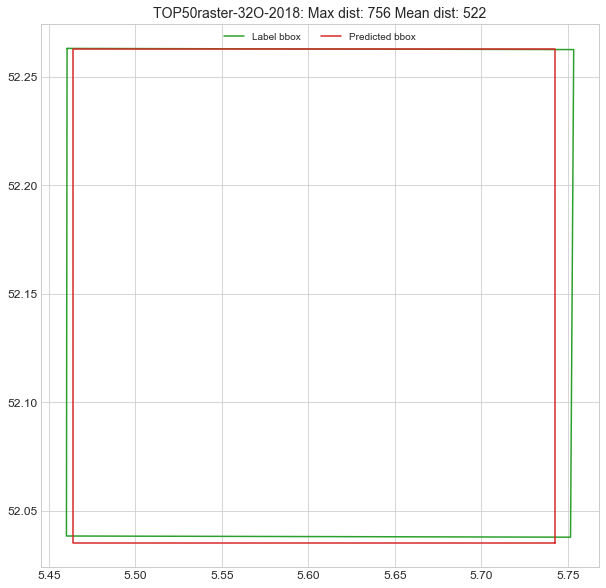


Current file: TOP50raster-32W-2018.jpg
Total geolocations: 20696 geolocations per line: 35.2


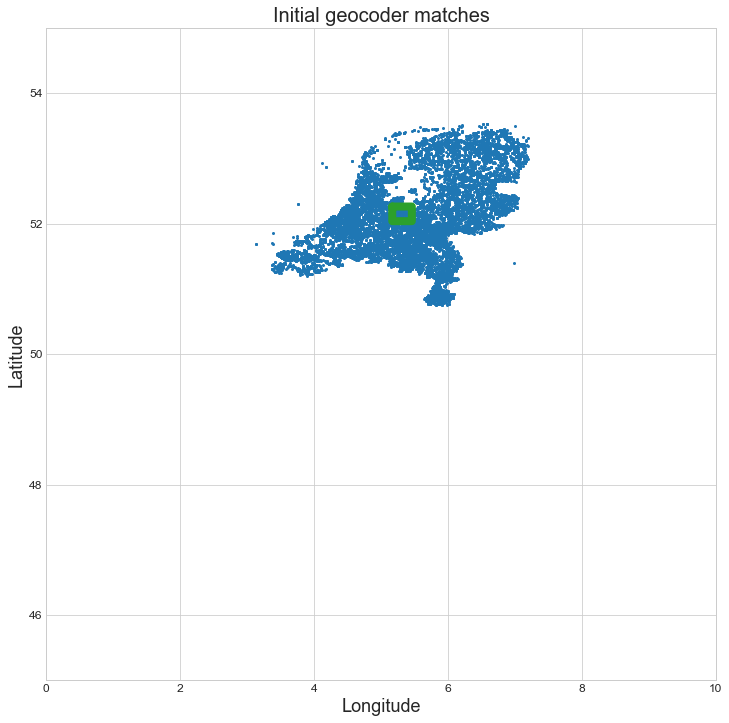

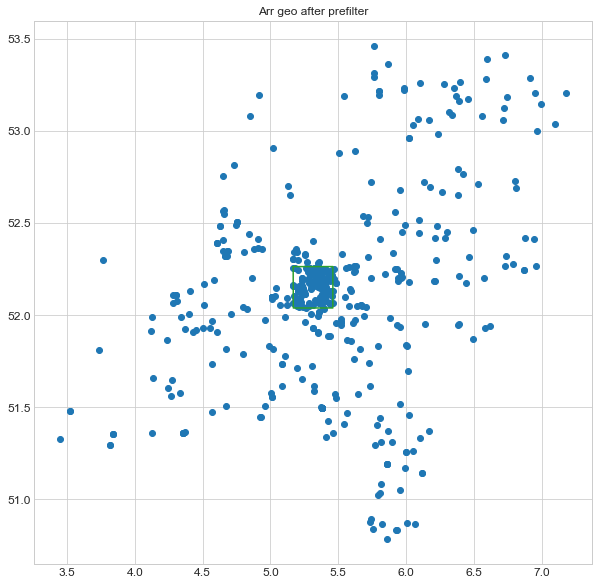


Prefilter filtered out: 0


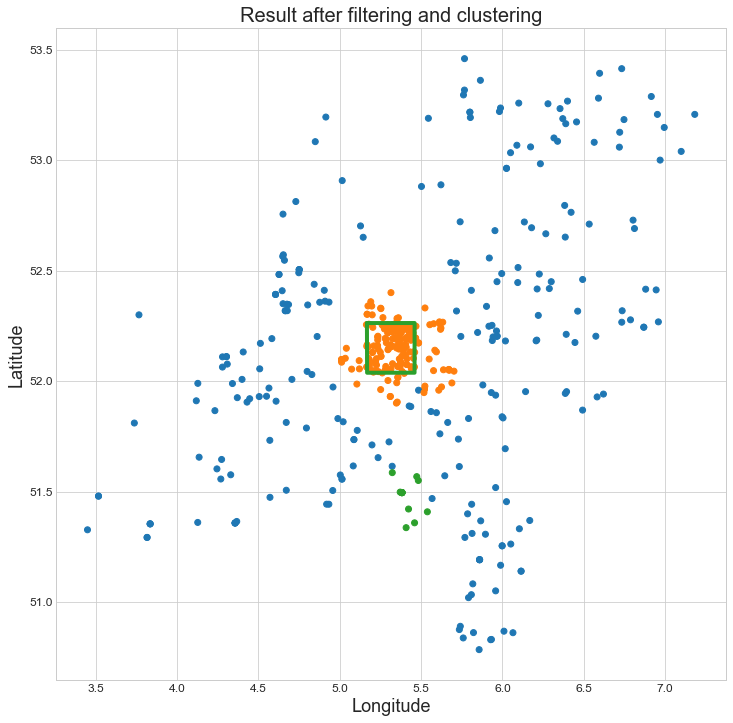

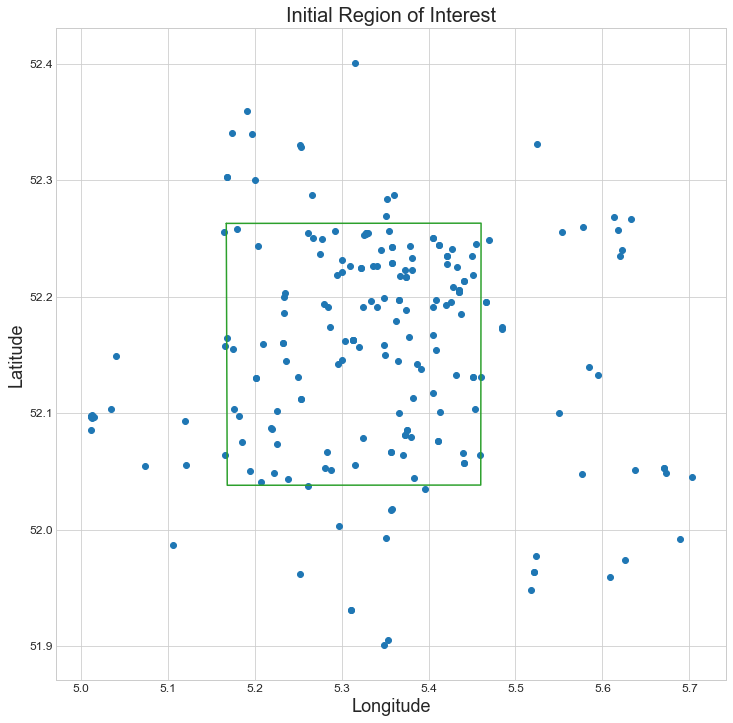

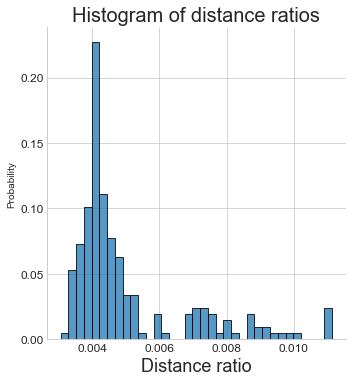

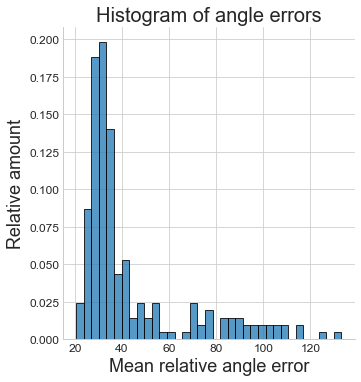


After error metric filtering
Total points inside: 66 Total points: 207


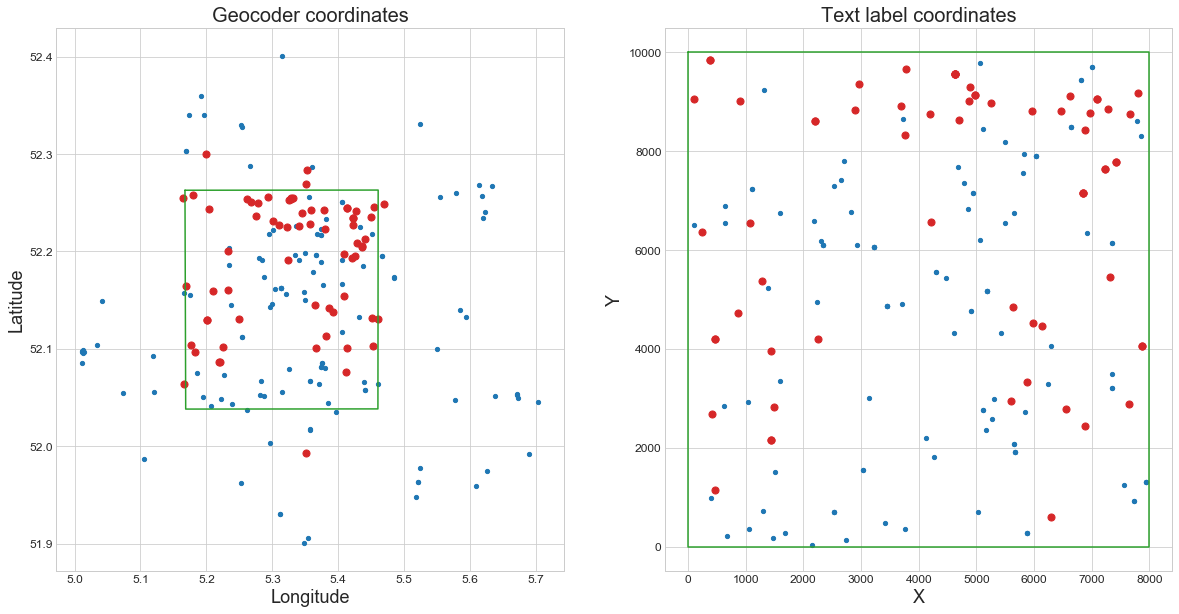

After warping map bounds:


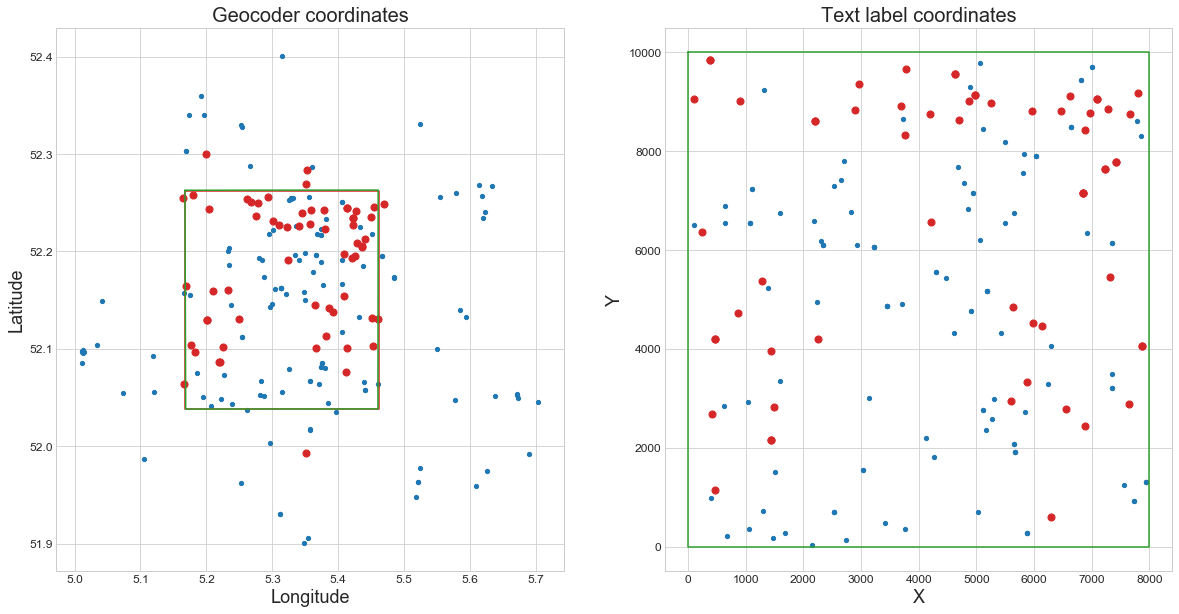

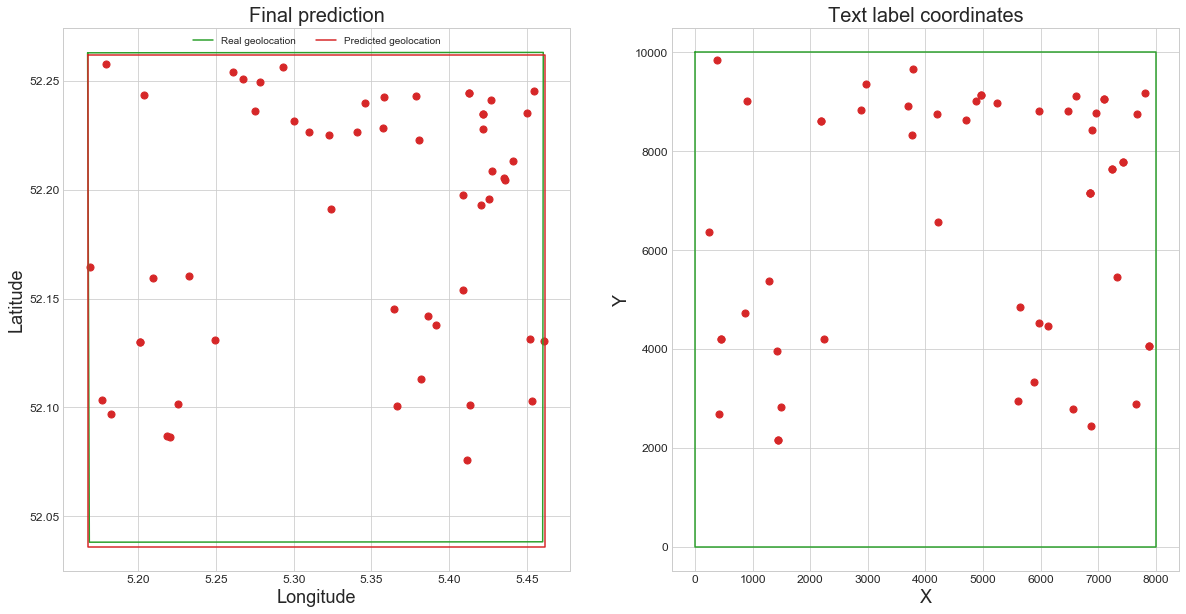

Max dist of bounds: 270 m
Mean dist of bounds: 199 m
Center dist: 186 scale: 0.0058


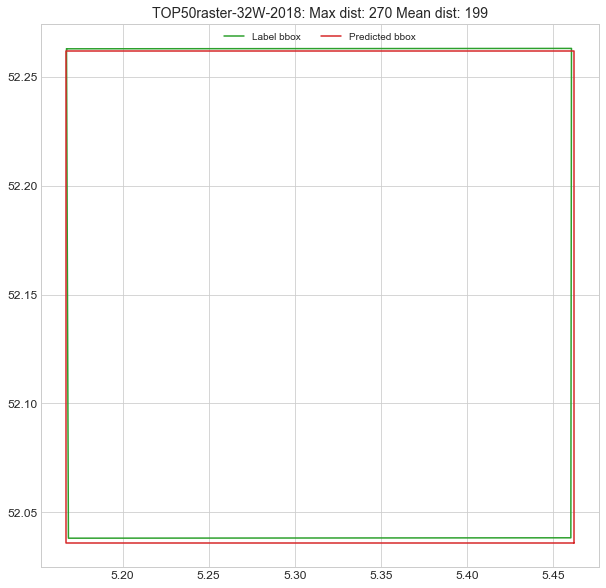


Current file: TOP50raster-38O-2018.jpg
Total geolocations: 38340 geolocations per line: 51.88


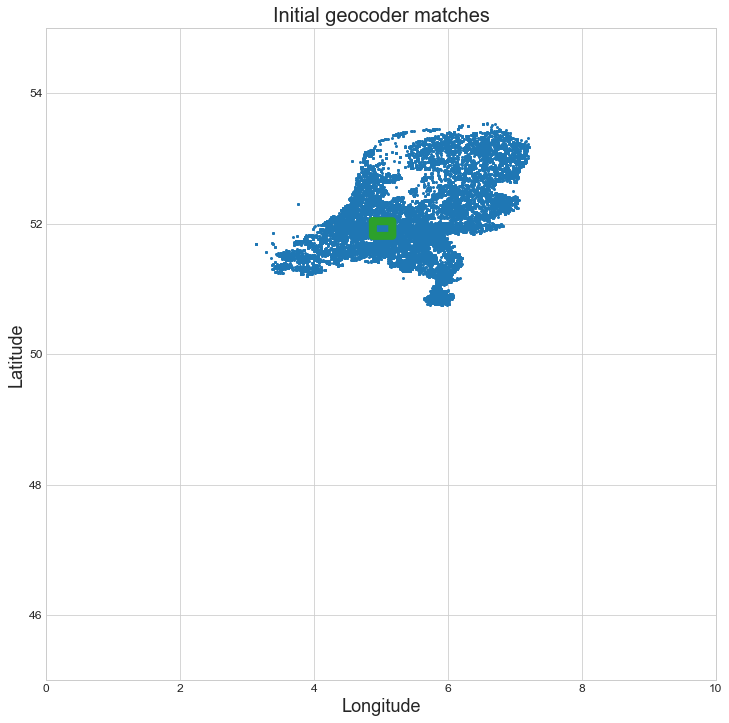

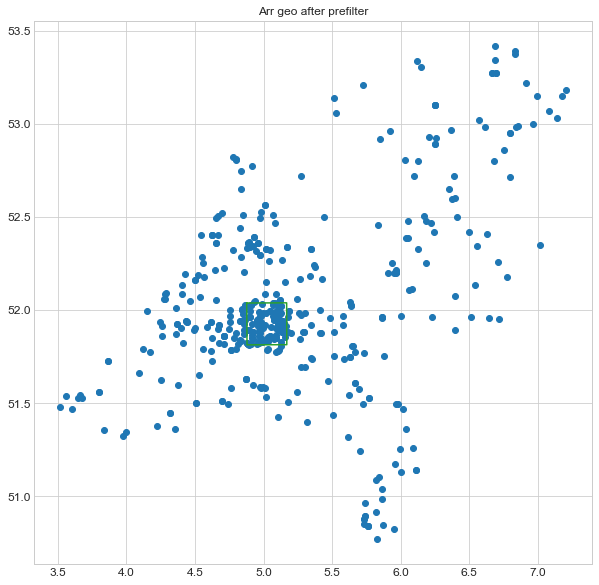


Prefilter filtered out: 0


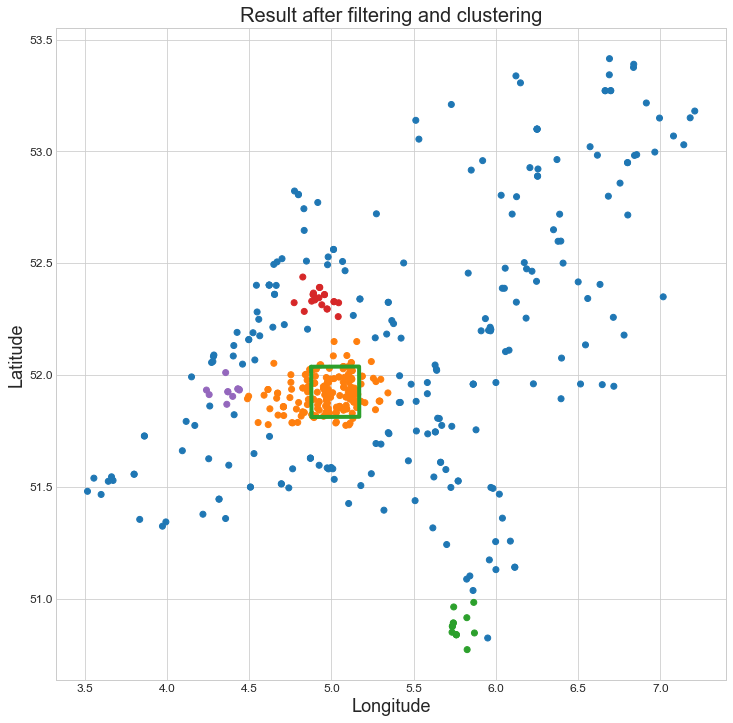

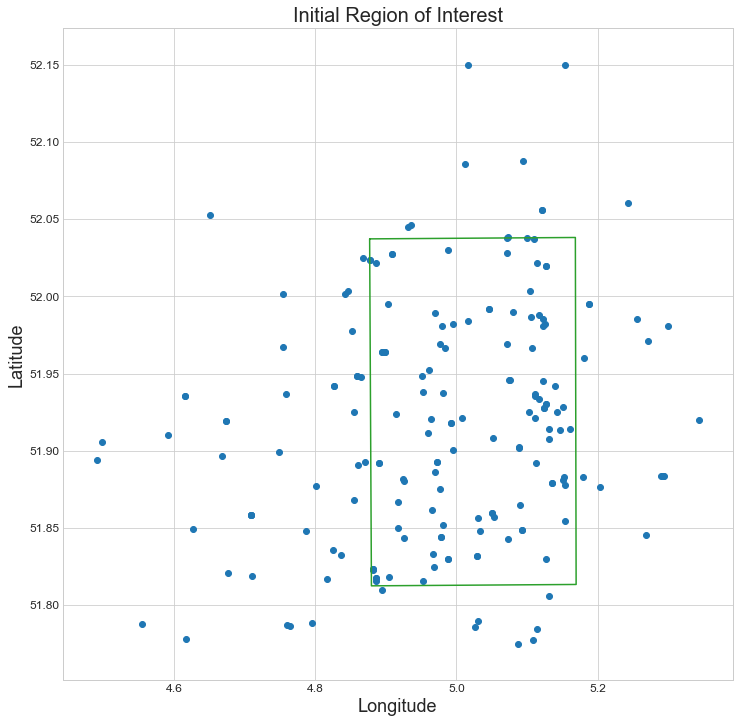

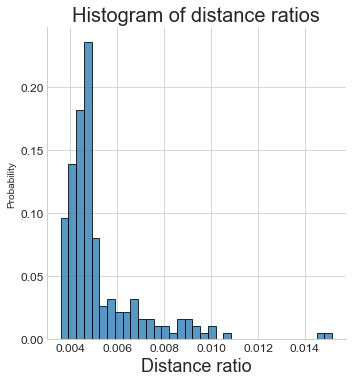

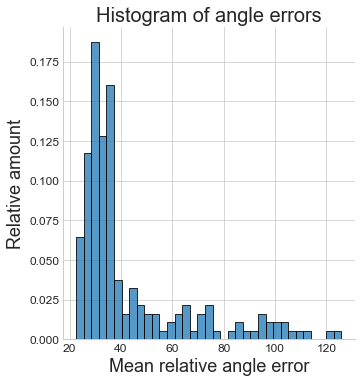


After error metric filtering
Total points inside: 58 Total points: 187


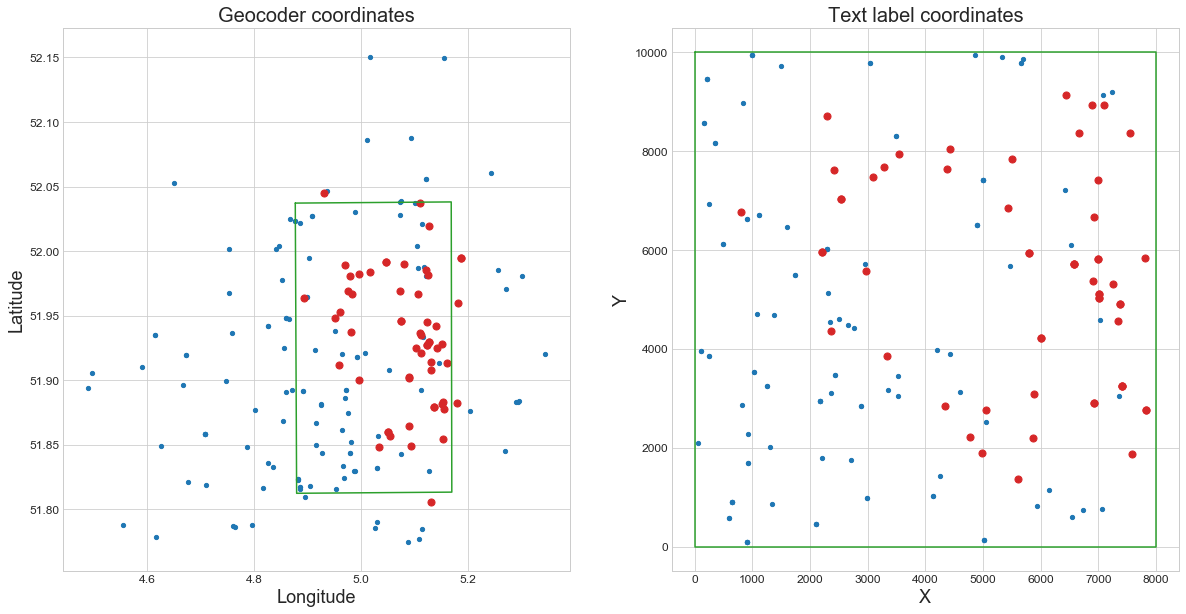

After warping map bounds:


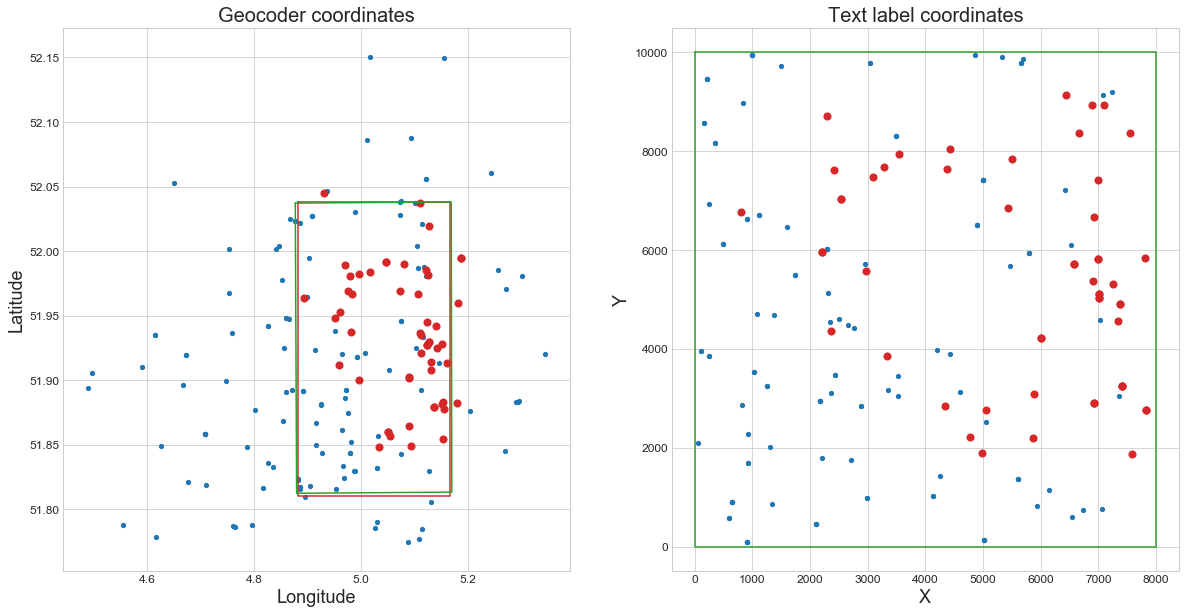

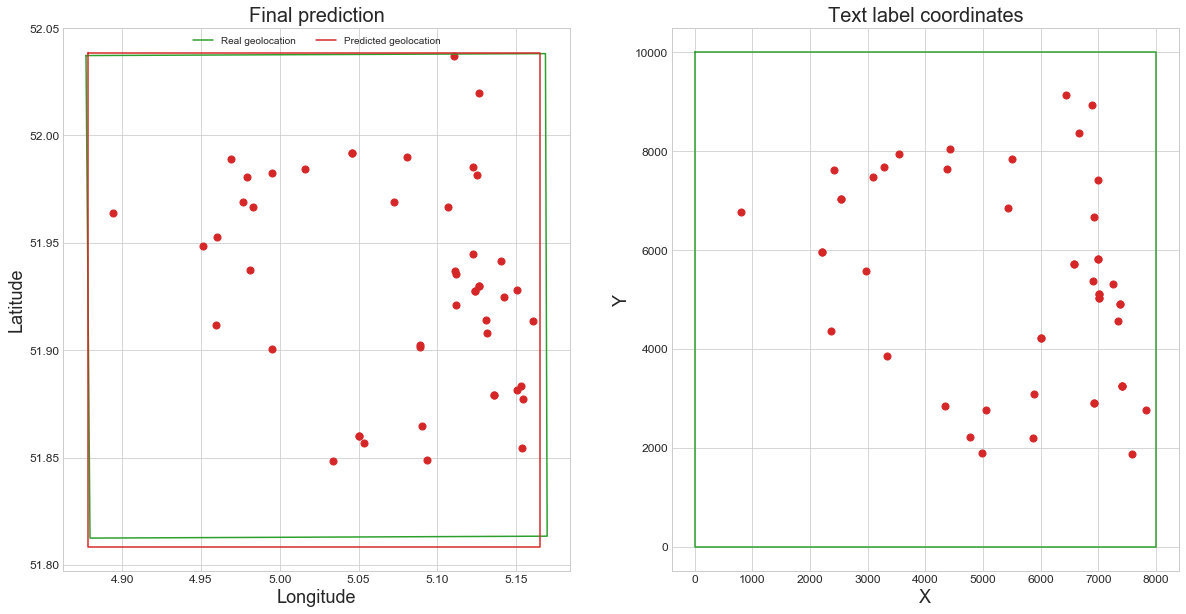

Max dist of bounds: 631 m
Mean dist of bounds: 373 m
Center dist: 248 scale: 0.0077


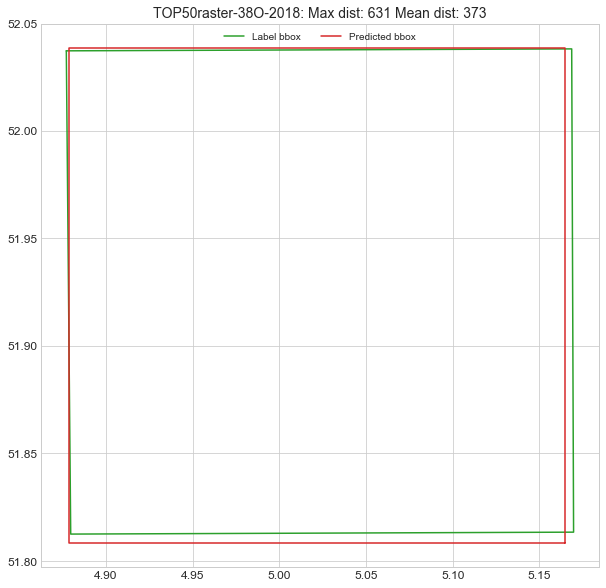


Current file: TOP50raster-39O-2018.jpg
Total geolocations: 23775 geolocations per line: 37.5


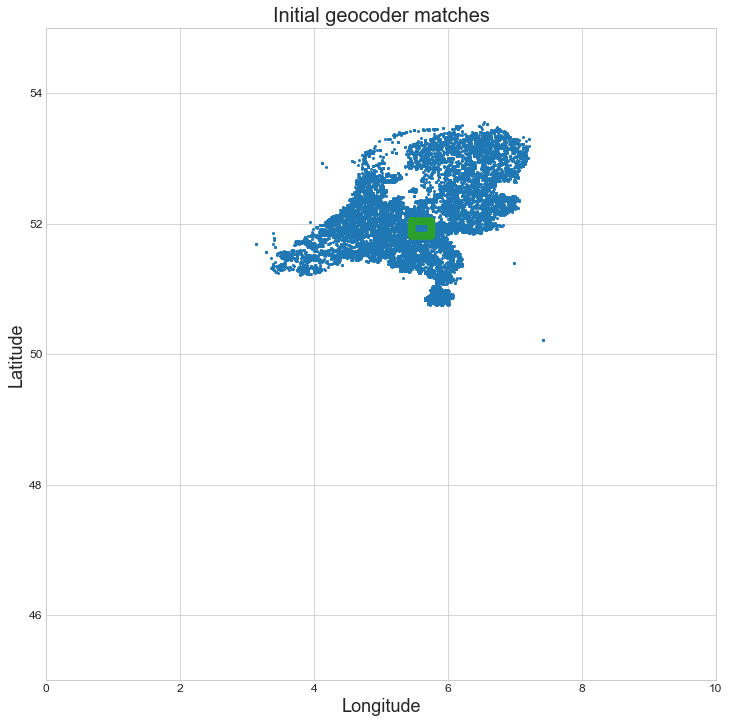

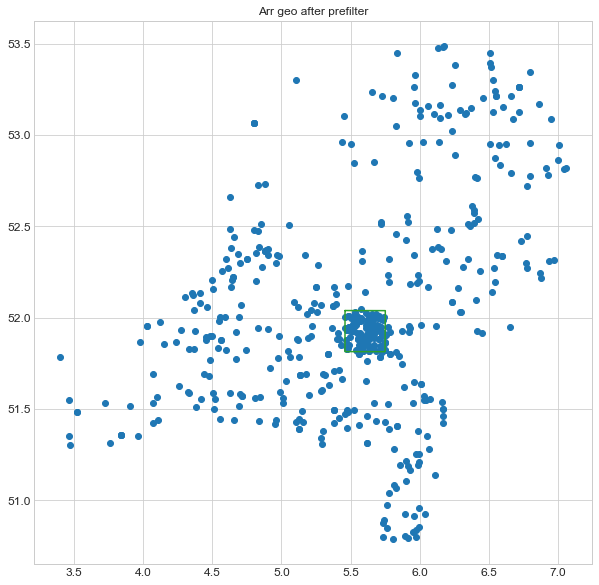


Prefilter filtered out: 0


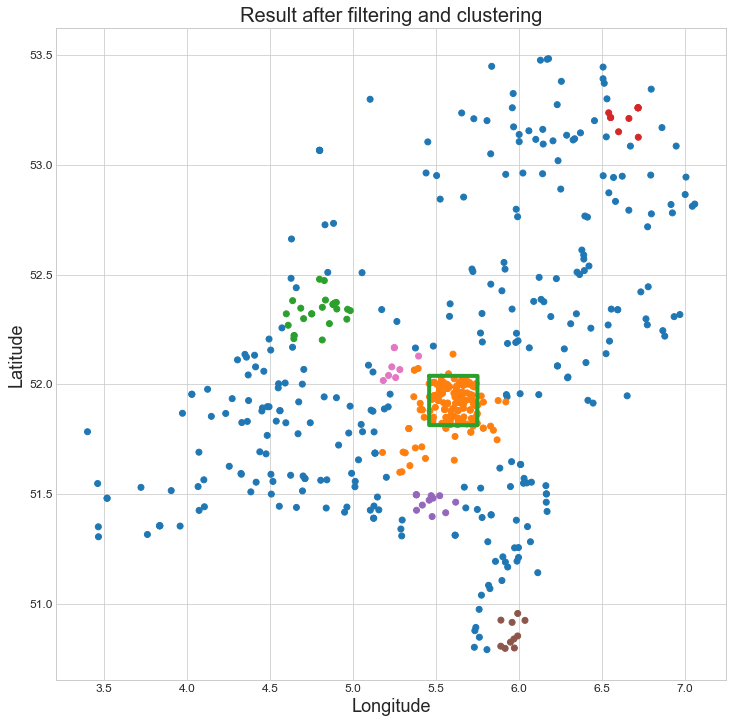

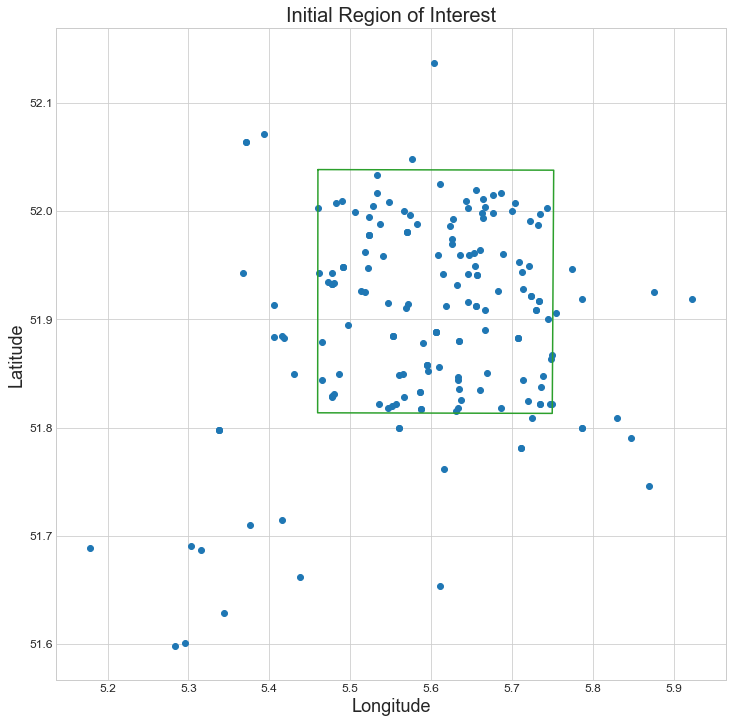

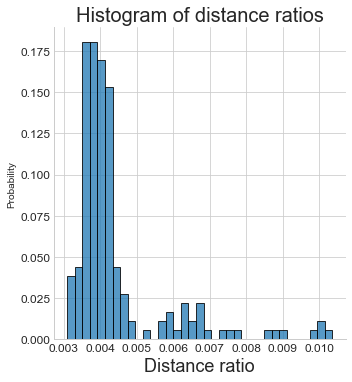

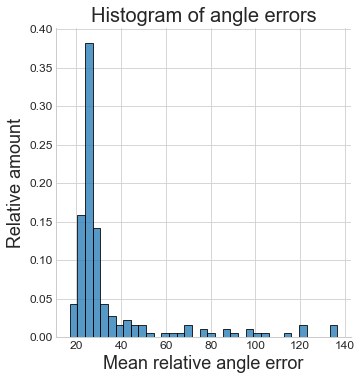


After error metric filtering
Total points inside: 53 Total points: 183


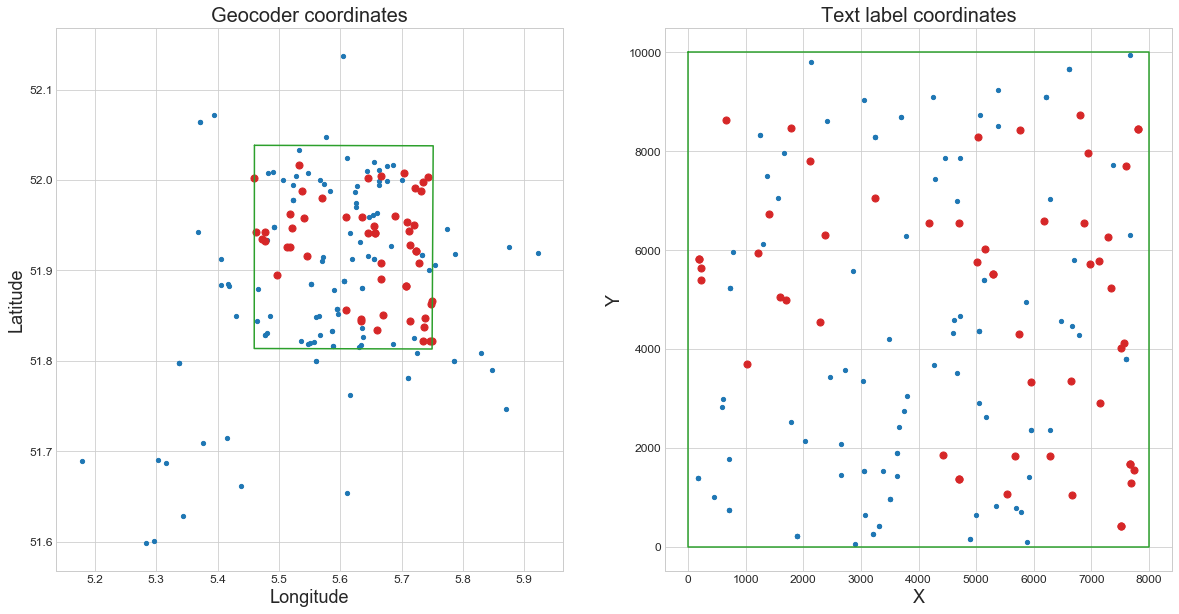

After warping map bounds:


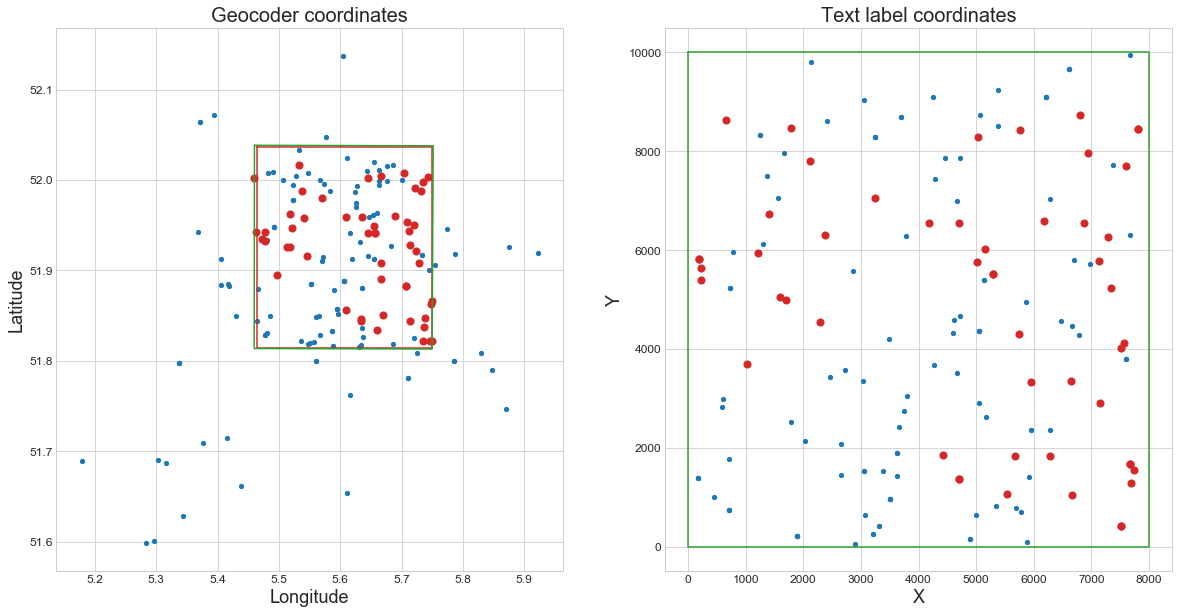

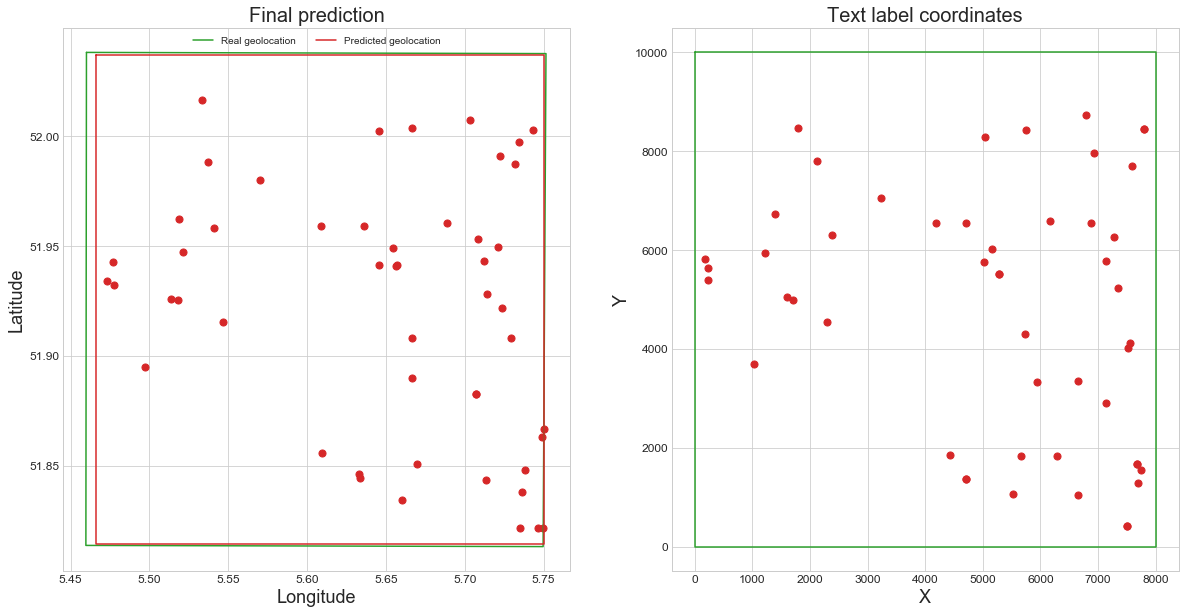

Max dist of bounds: 438 m
Mean dist of bounds: 270 m
Center dist: 207 scale: 0.0065


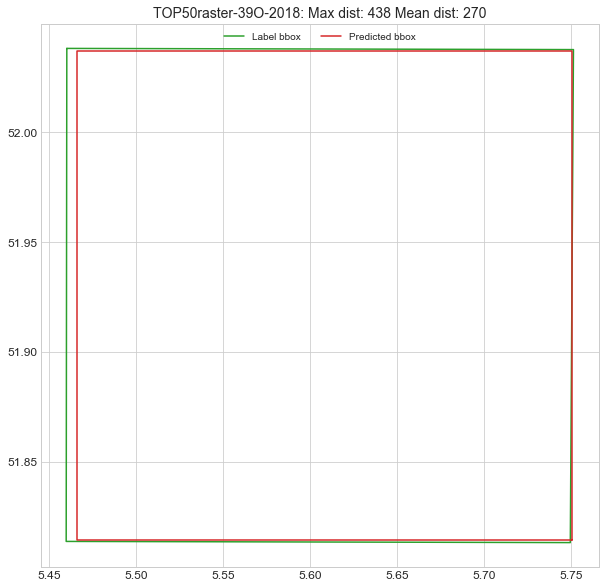


Current file: TOP50raster-39W-2018.jpg
Total geolocations: 32302 geolocations per line: 41.41


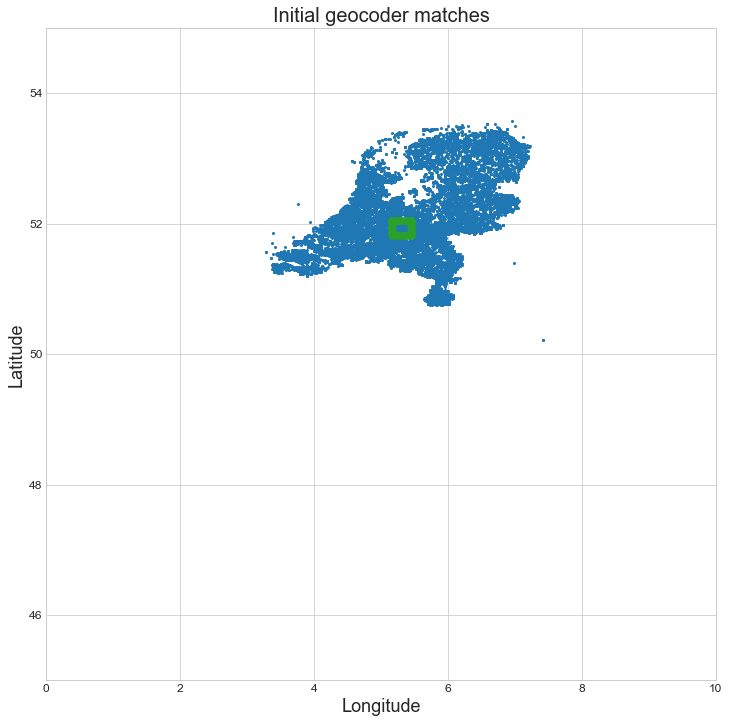

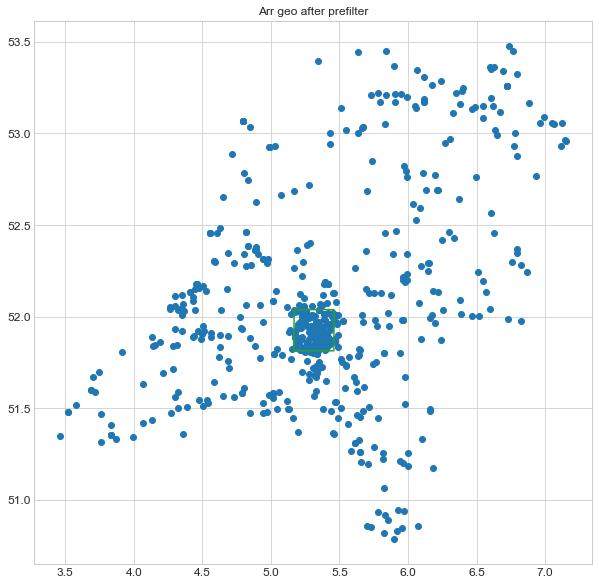


Prefilter filtered out: 0


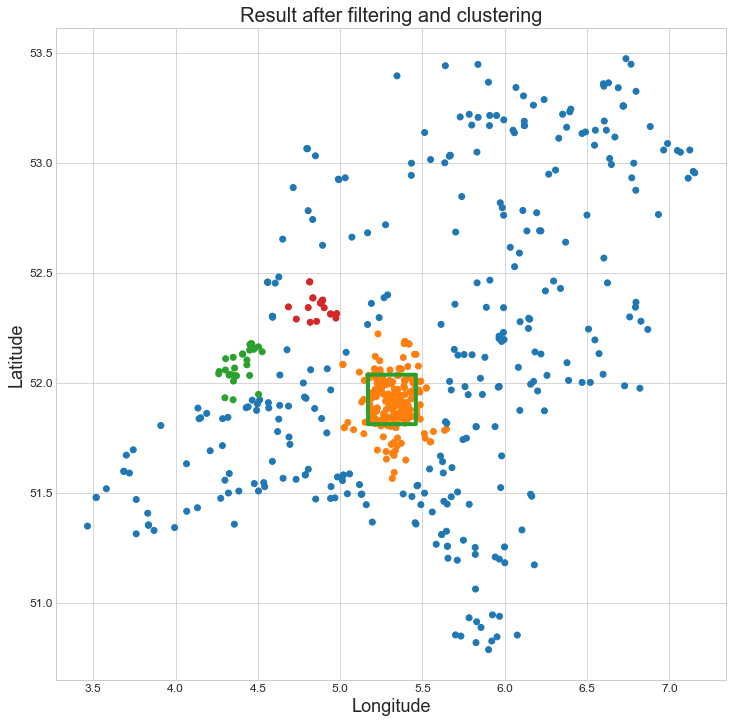

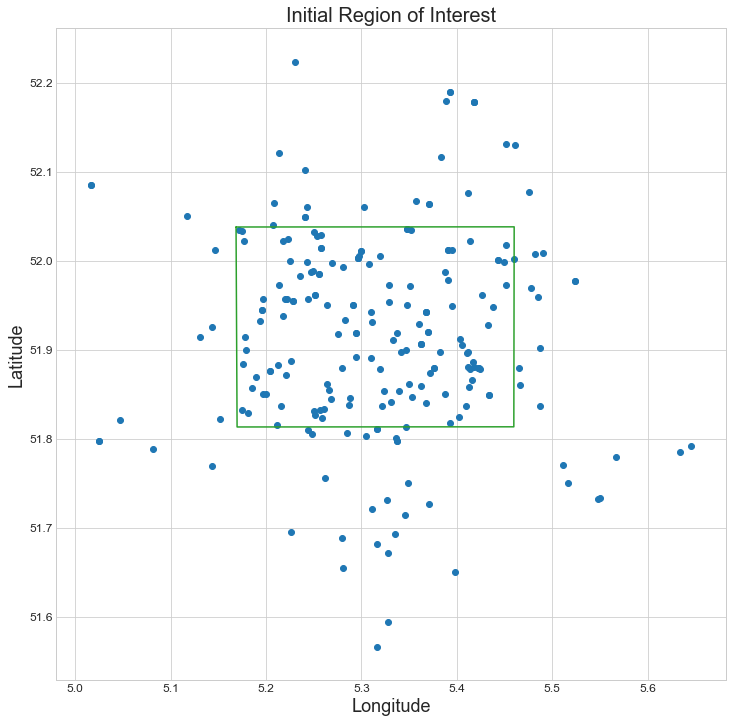

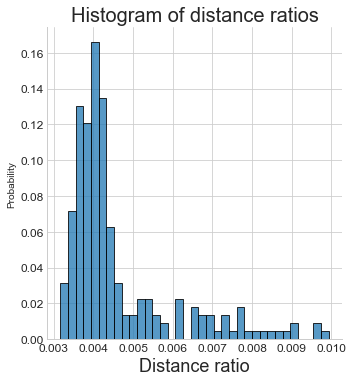

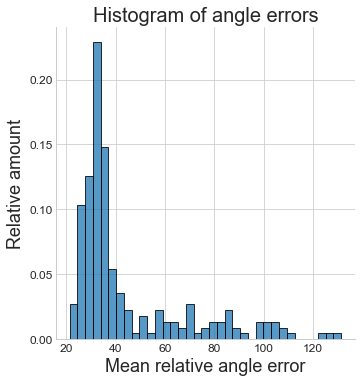


After error metric filtering
Total points inside: 73 Total points: 223


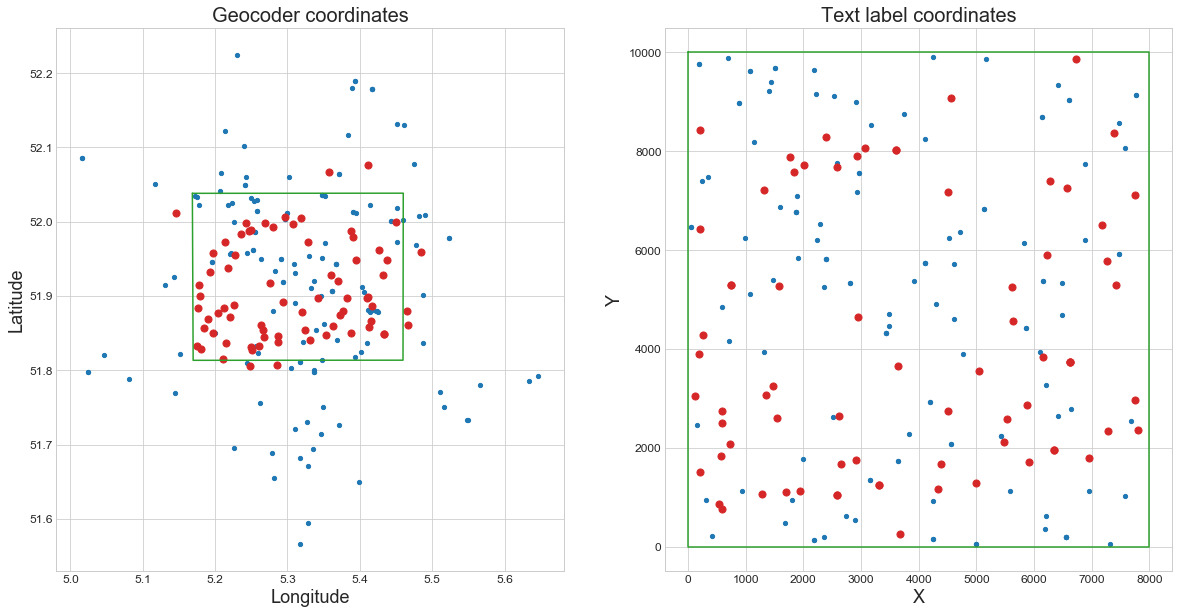

After warping map bounds:


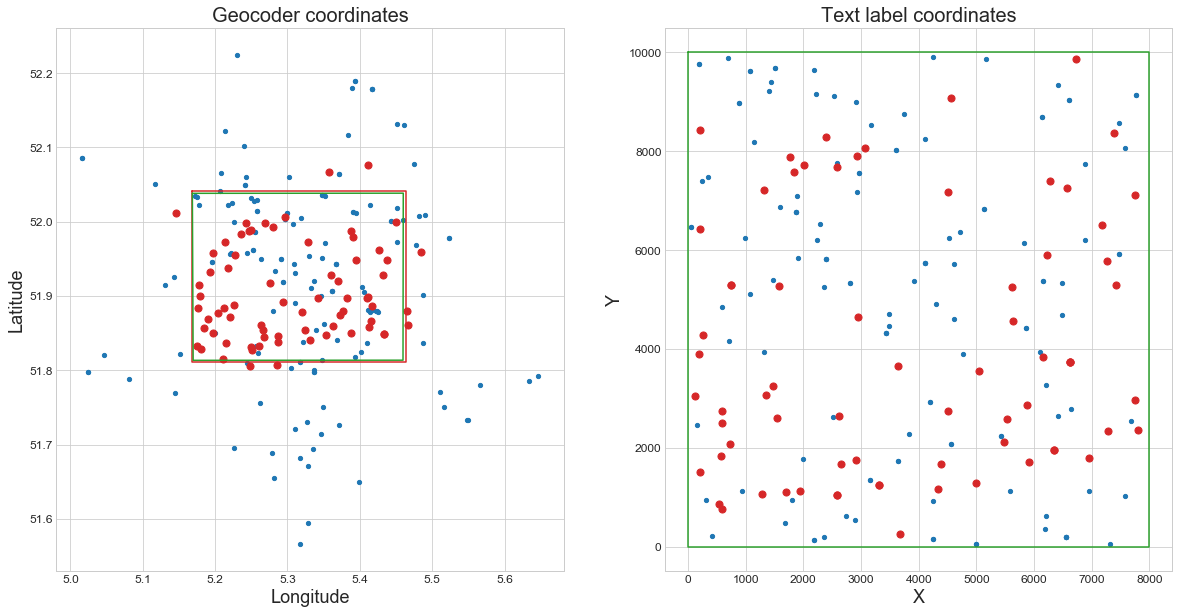

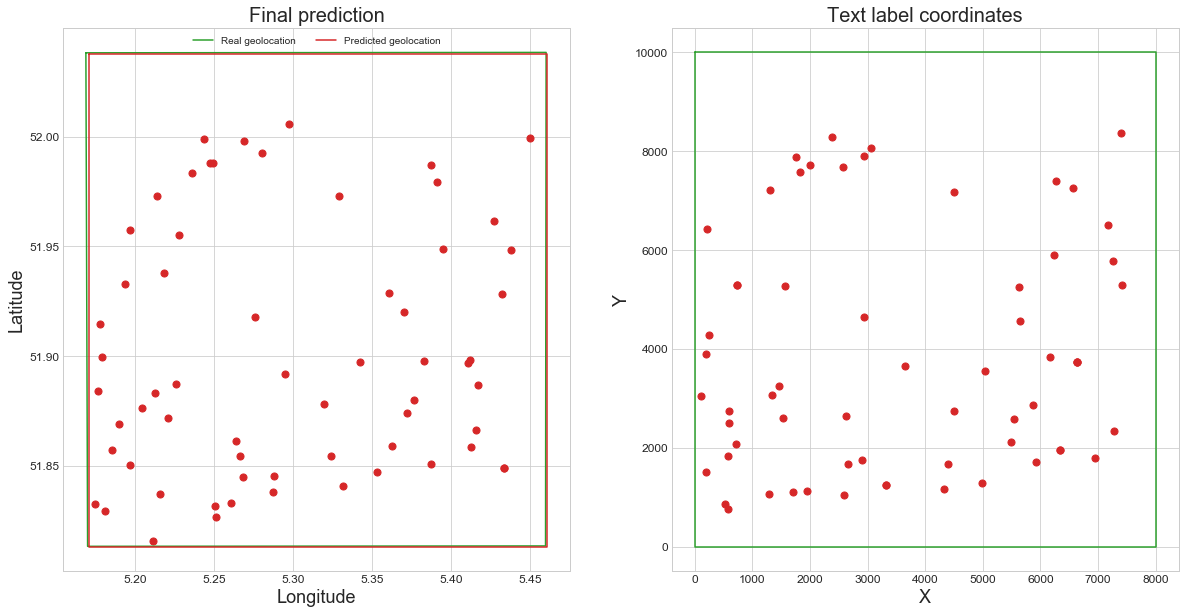

Max dist of bounds: 132 m
Mean dist of bounds: 83 m
Center dist: 80 scale: 0.0025


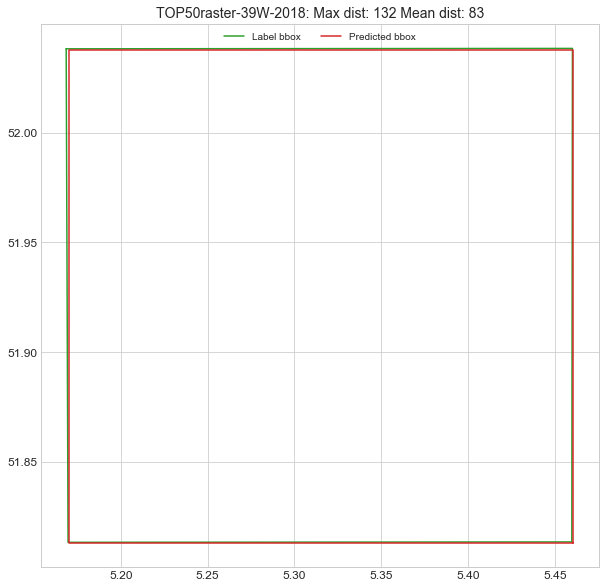


Current file: TOP50raster-44O-2018.jpg
Total geolocations: 31929 geolocations per line: 45.74


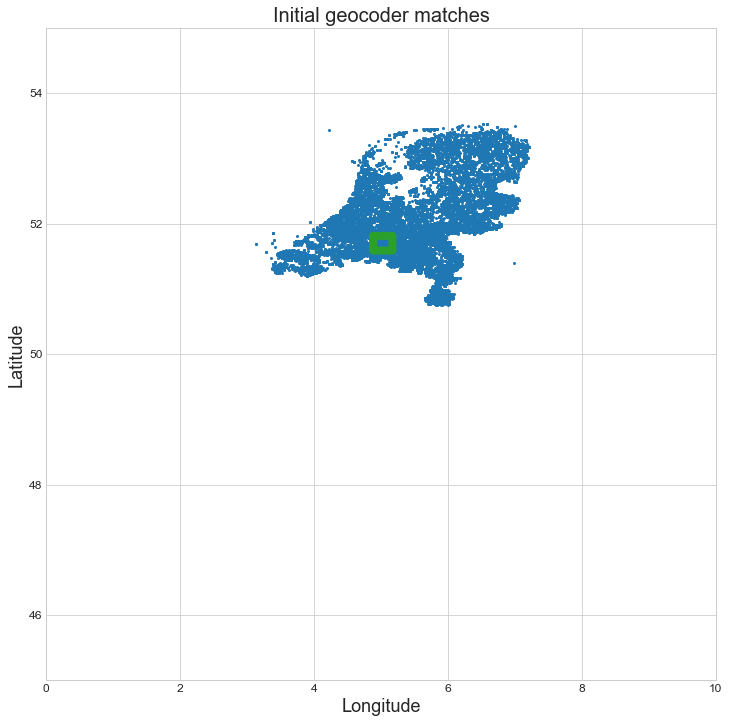

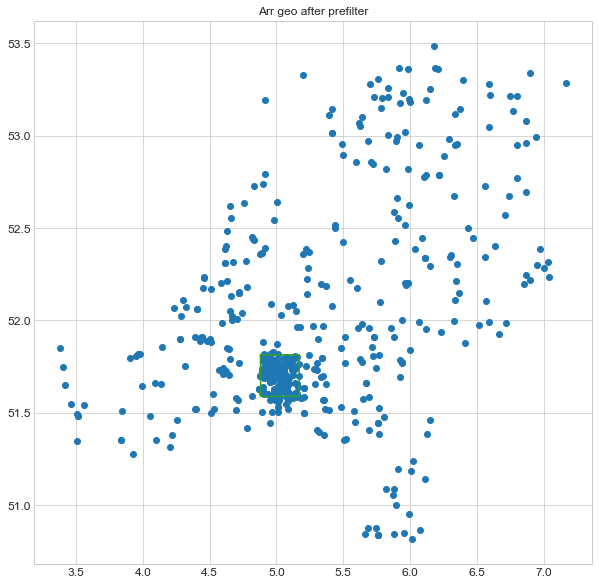


Prefilter filtered out: 0


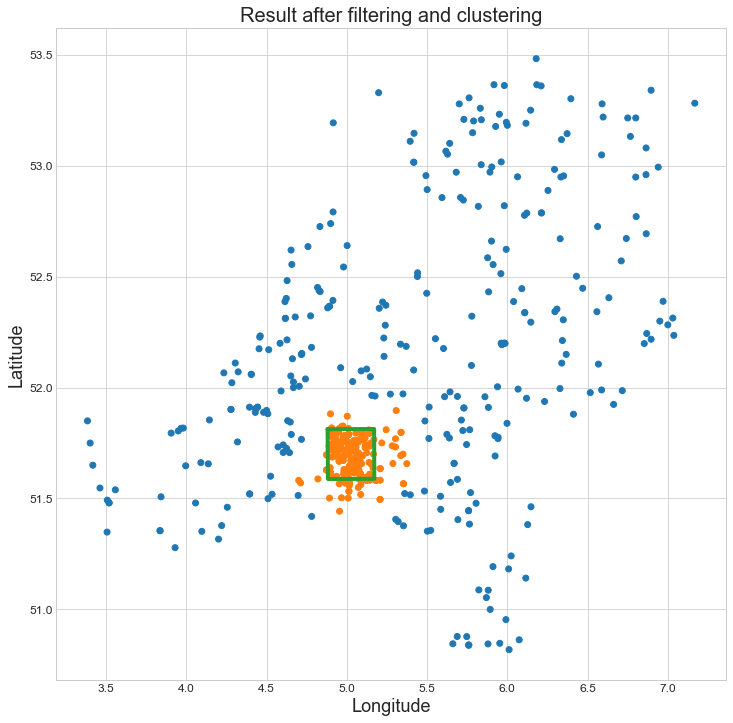

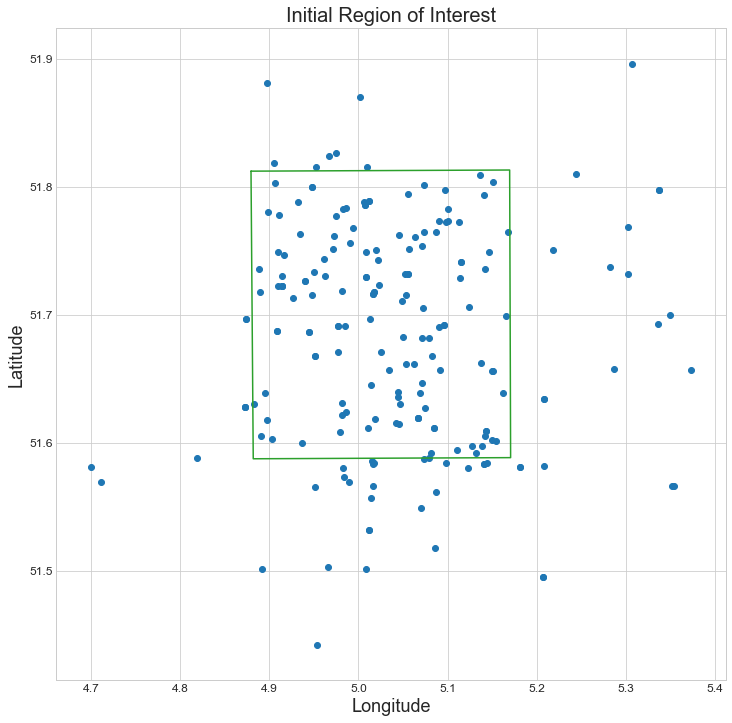

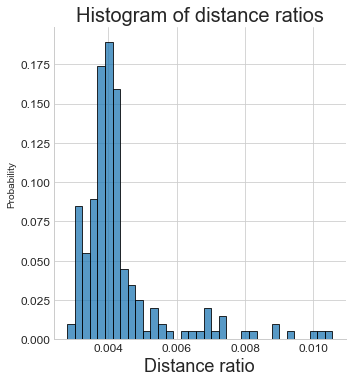

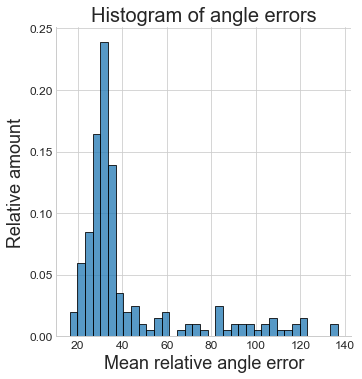


After error metric filtering
Total points inside: 64 Total points: 201


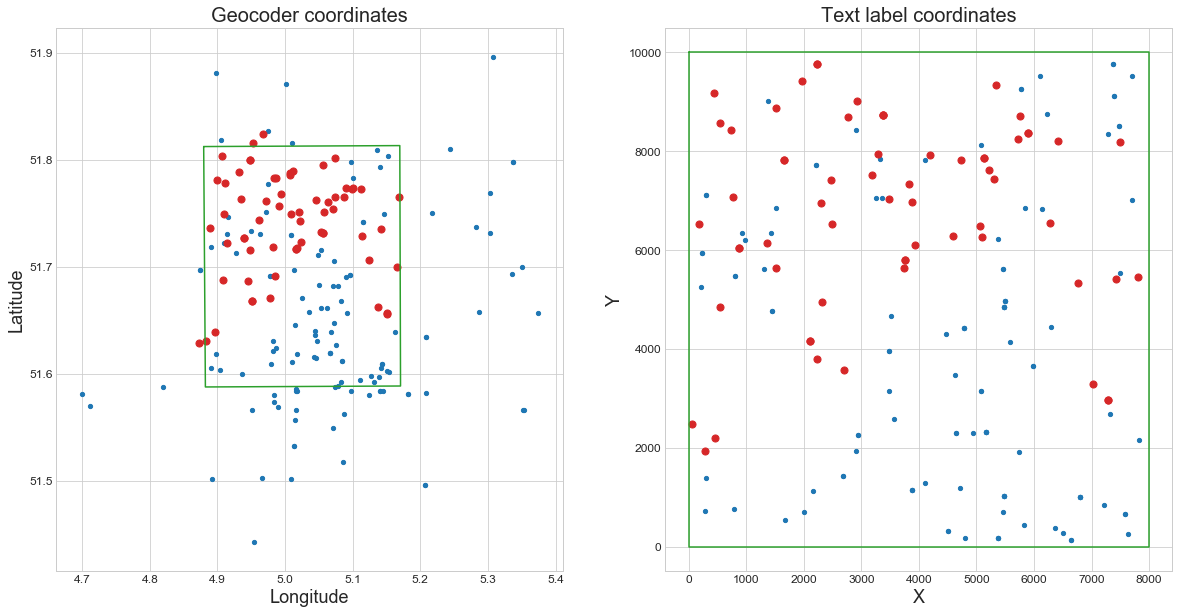

After warping map bounds:


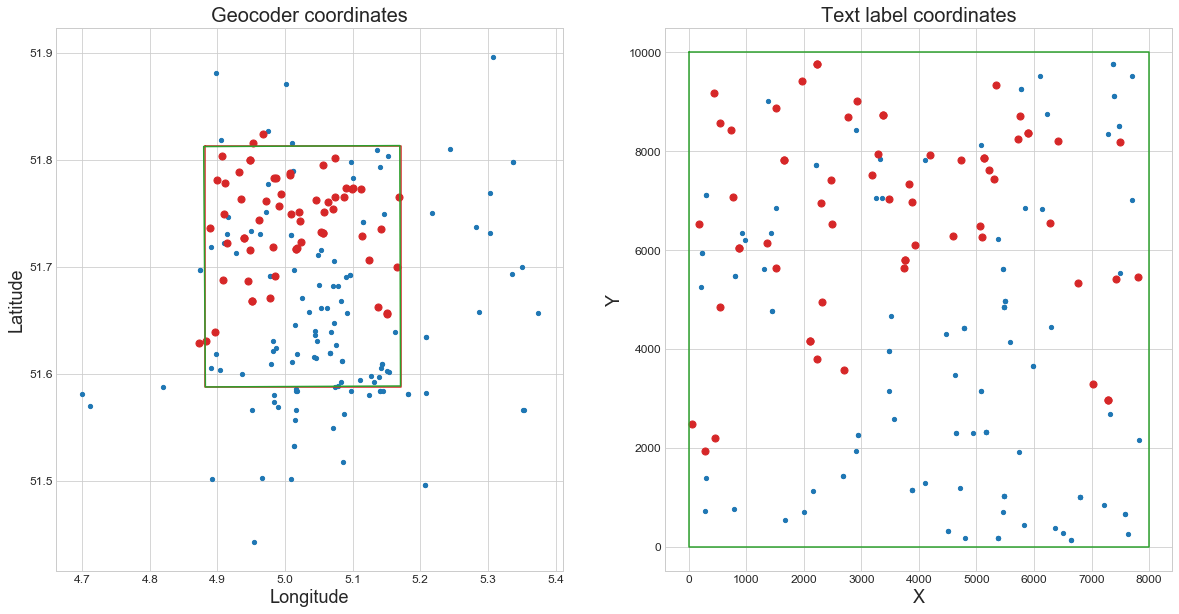

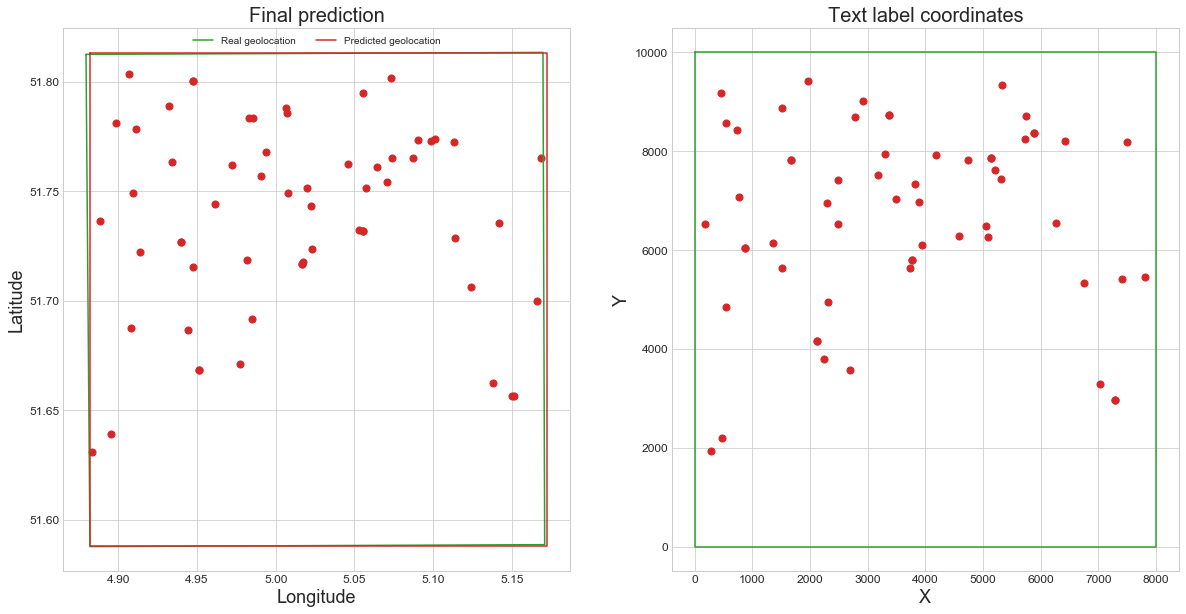

Max dist of bounds: 185 m
Mean dist of bounds: 132 m
Center dist: 110 scale: 0.0034


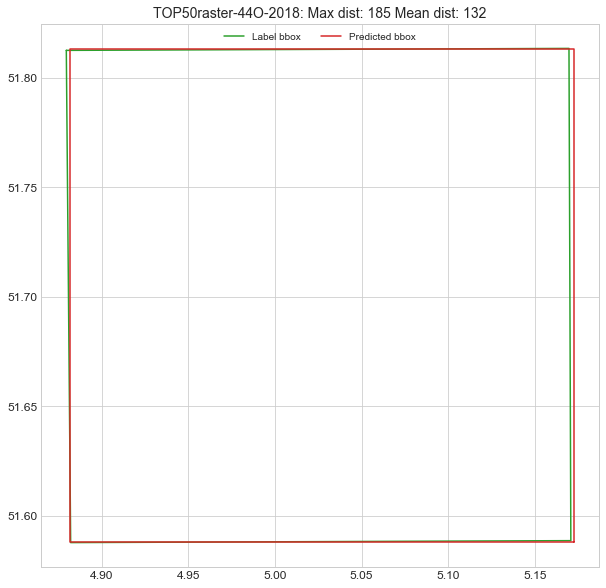


Current file: TOP50raster-45O-2018.jpg
Total geolocations: 24683 geolocations per line: 40.27


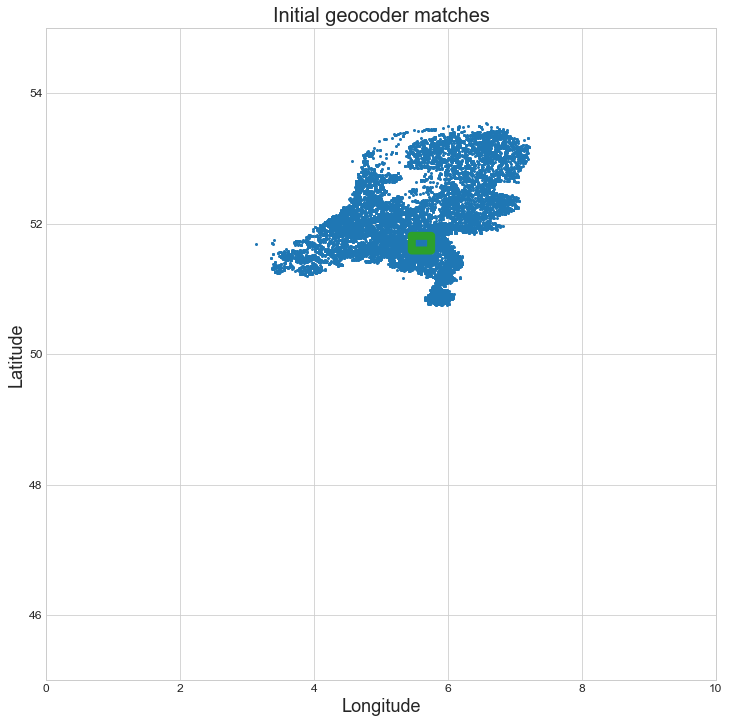

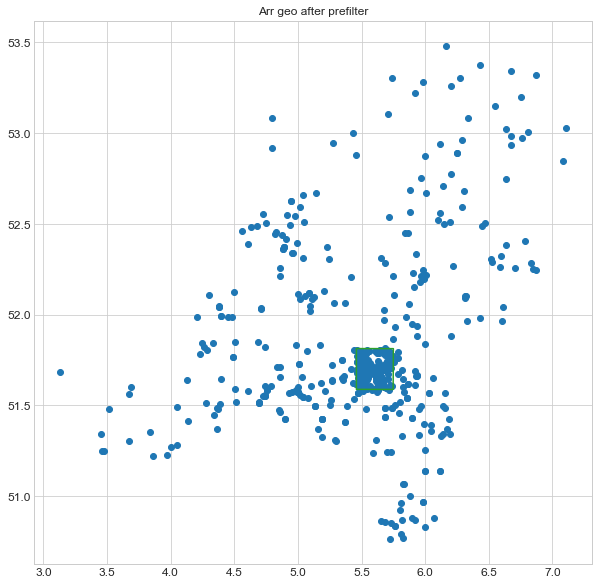


Prefilter filtered out: 0


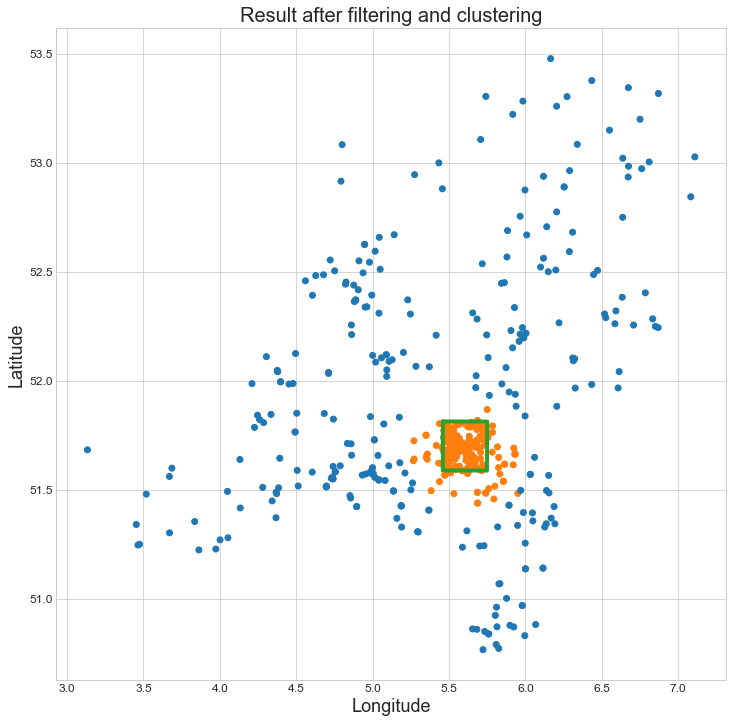

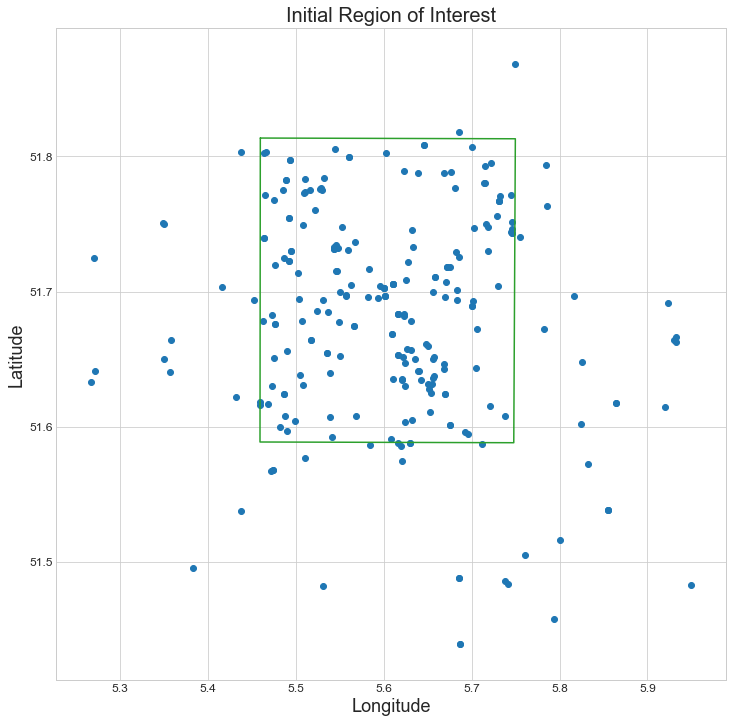

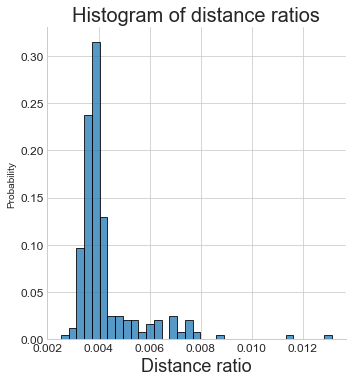

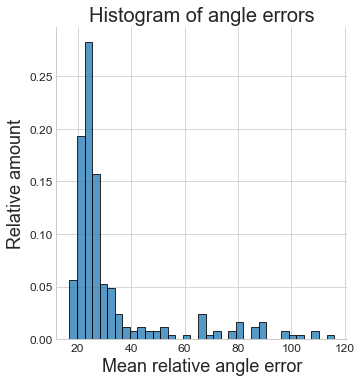


After error metric filtering
Total points inside: 76 Total points: 248


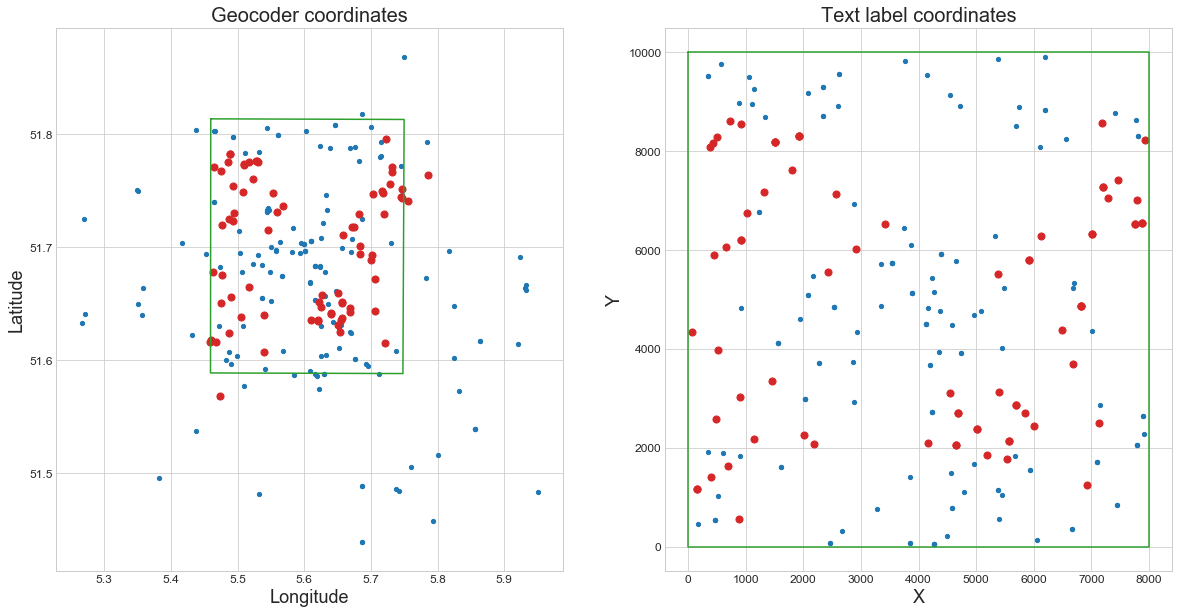

After warping map bounds:


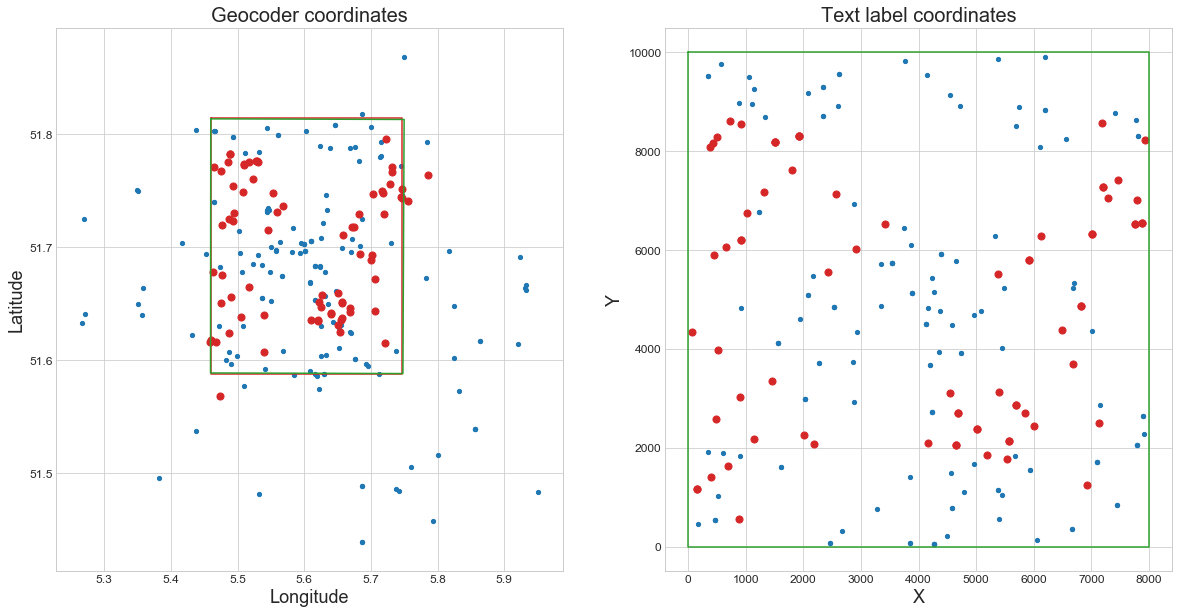

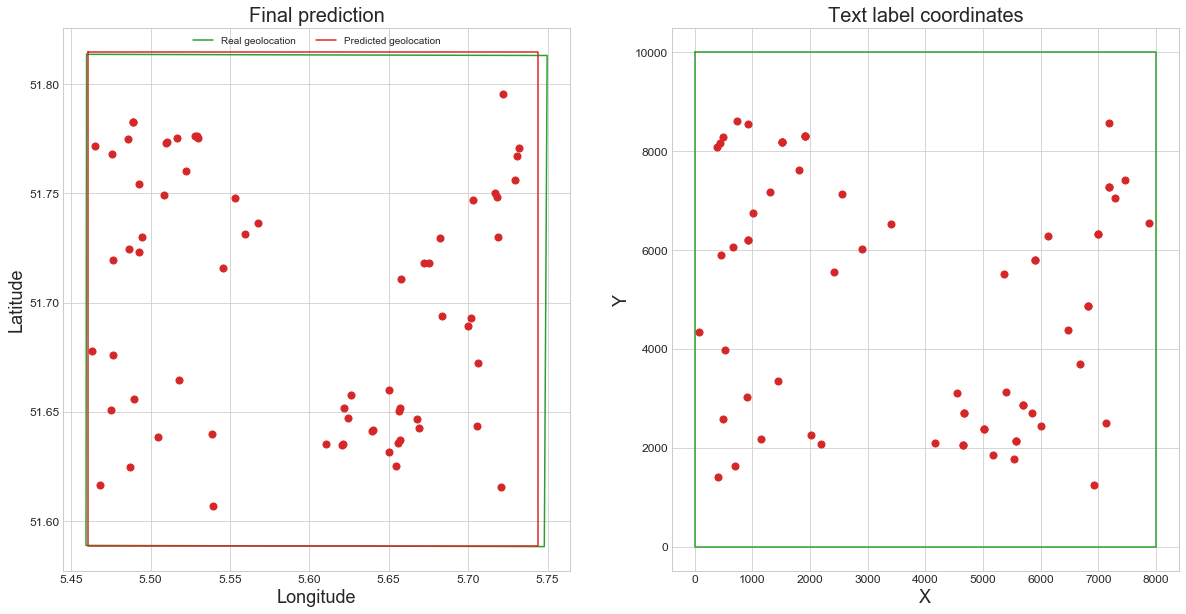

Max dist of bounds: 419 m
Mean dist of bounds: 223 m
Center dist: 146 scale: 0.0045


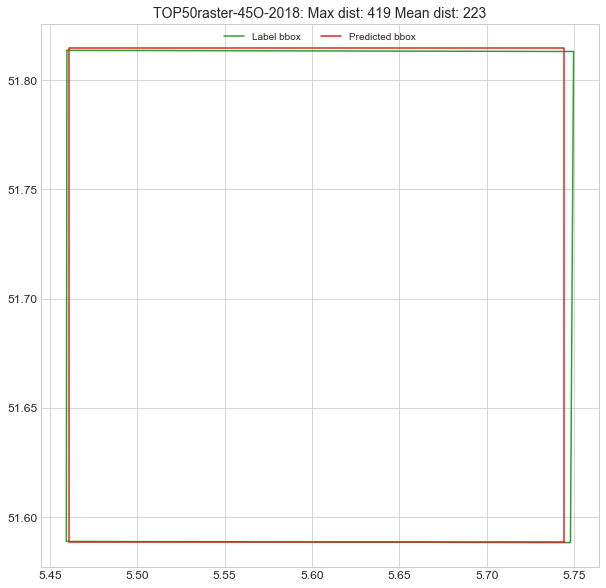


Current file: TOP50raster-45W-2018.jpg
Total geolocations: 30375 geolocations per line: 41.21


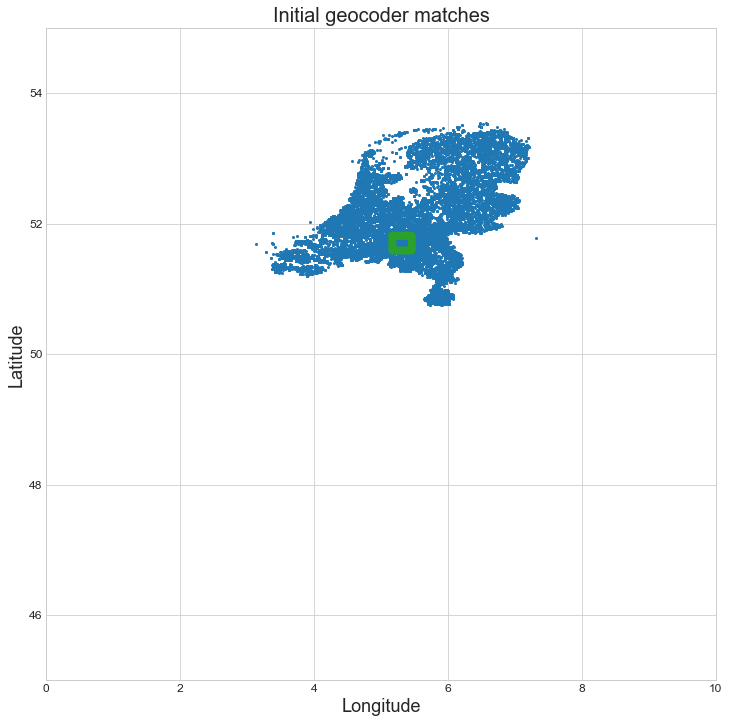

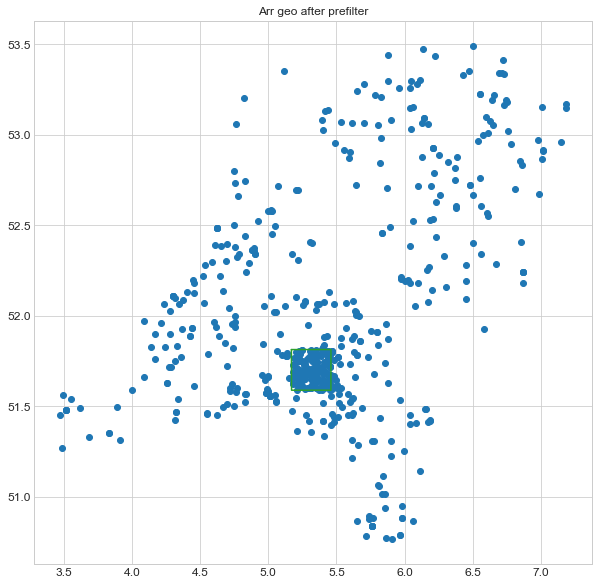


Prefilter filtered out: 0


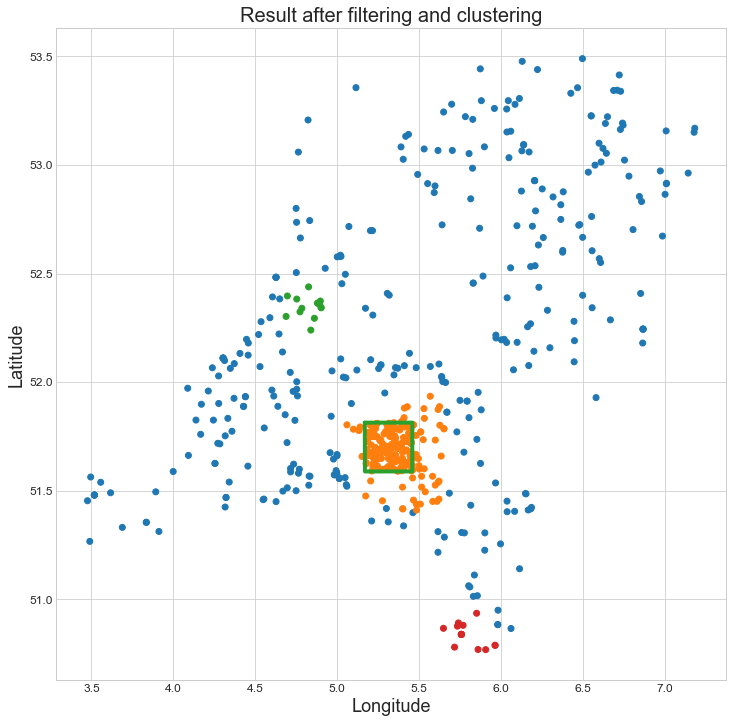

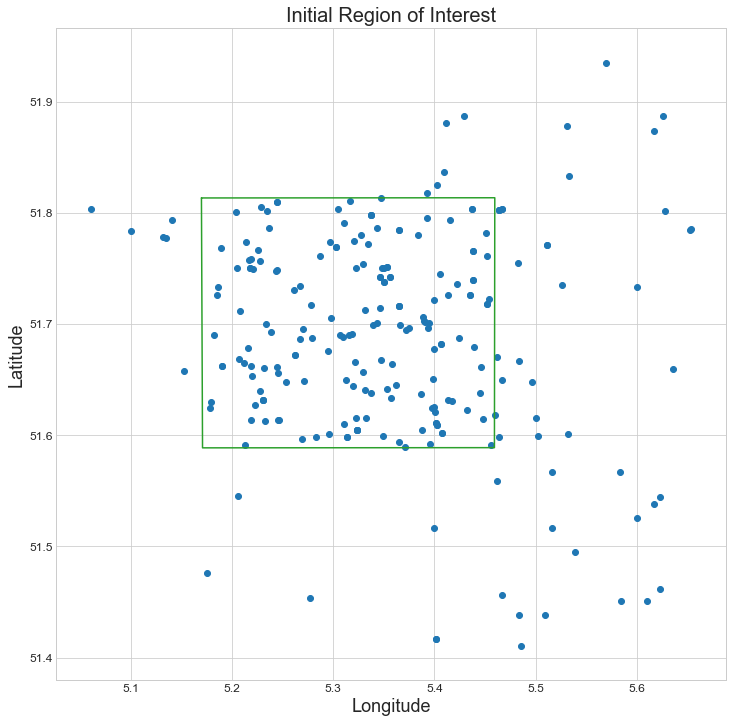

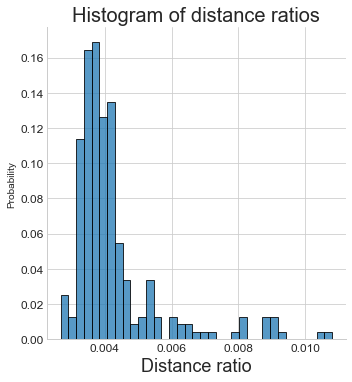

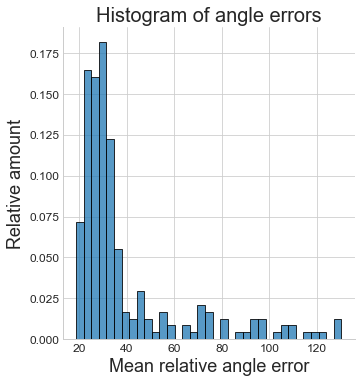


After error metric filtering
Total points inside: 70 Total points: 237


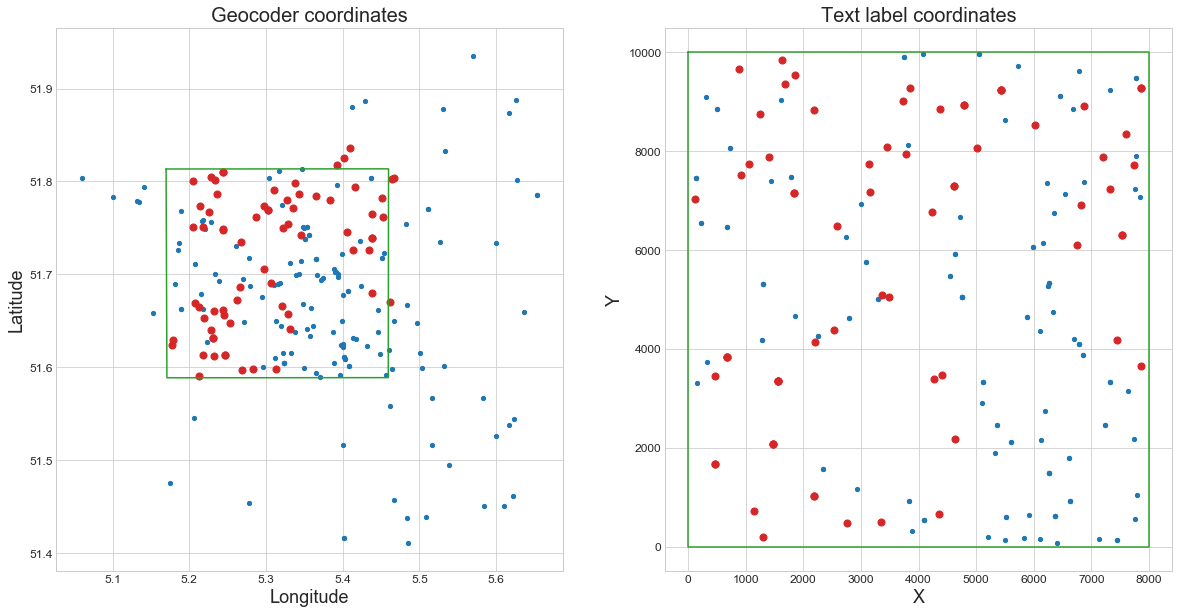

After warping map bounds:


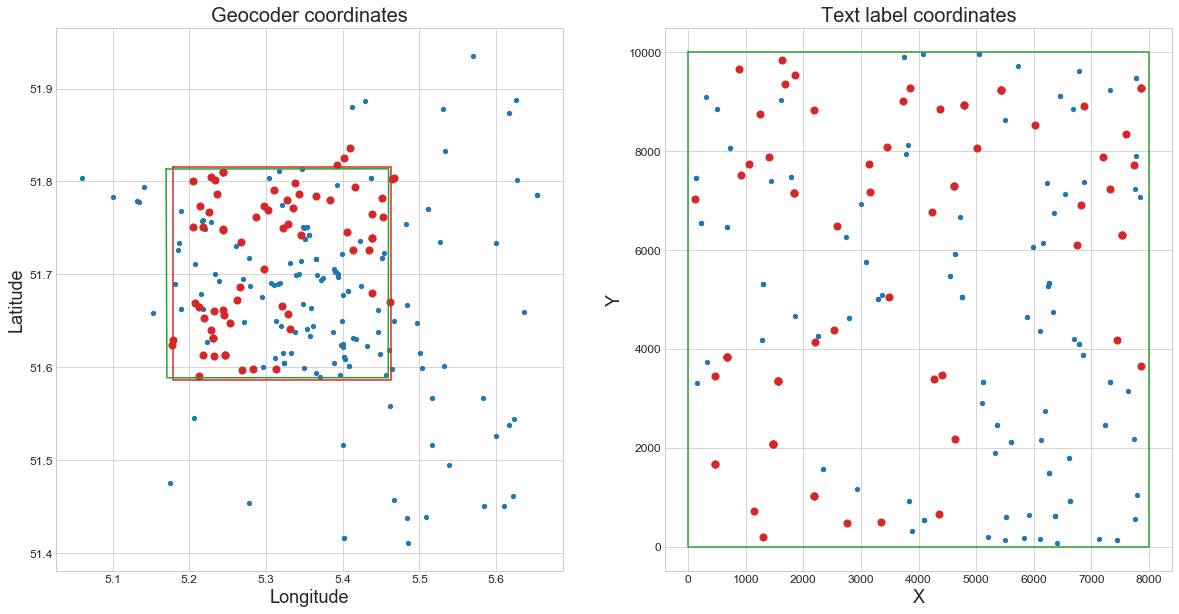

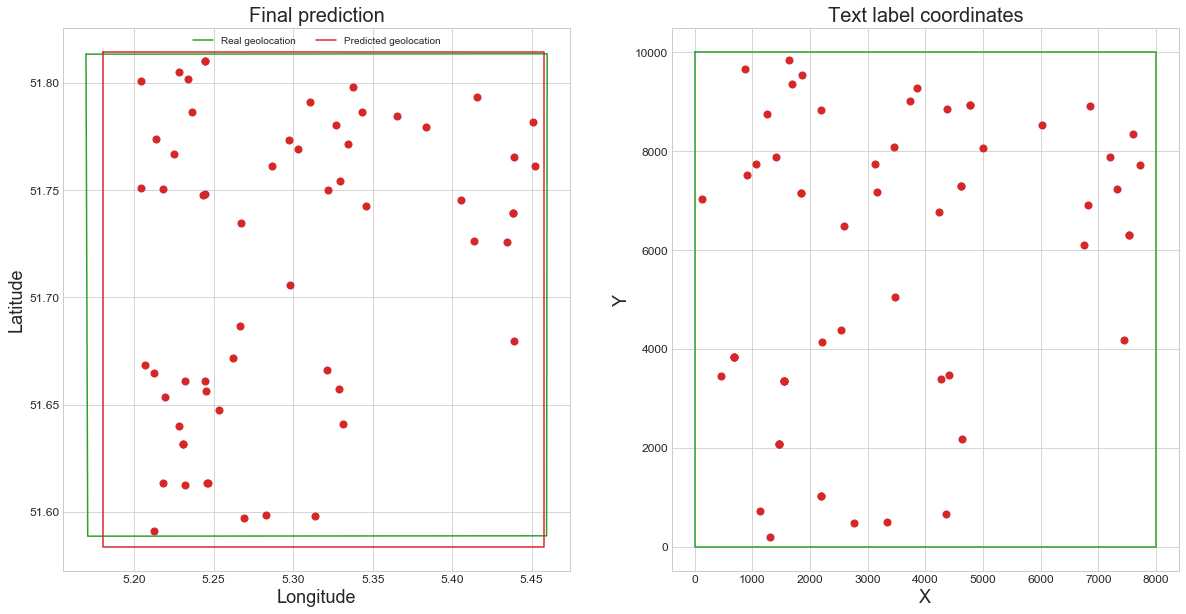

Max dist of bounds: 863 m
Mean dist of bounds: 586 m
Center dist: 372 scale: 0.0116


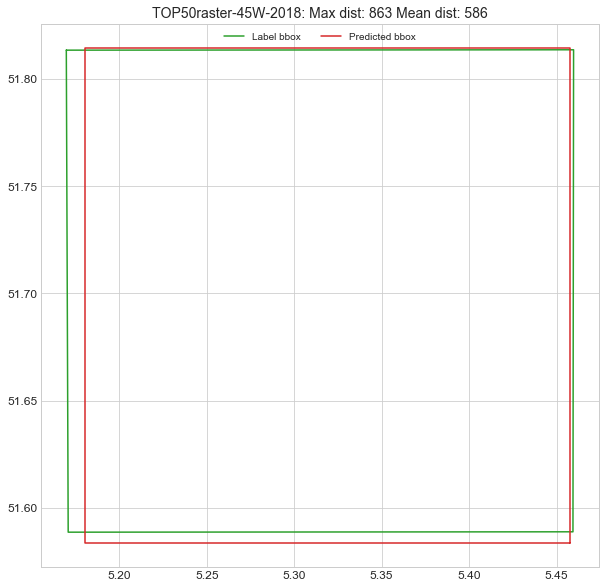

In [60]:
data_dir = 'dataset/TOP50raster'
img_dir = os.path.join(data_dir,'cropped')
json_dir = os.path.join(data_dir,'json')
plot_dir = os.path.join(data_dir,'plots')
n_geojson = 0
counter = 0

results = []
fnames_not_geolocated = []
plot = True
save_plot = False
verbose = 1

all_label_polygons = []
all_bounds = []
all_mean_dists = []
all_max_dists = []
all_center_dists = []
diag_dists = []

geo_max = 0
total_all_geo = 0

all_len_geos = []
all_step_bounds = []
all_label_bounds = []
for fname in os.listdir(img_dir):
    counter += 1
    if '-Copy' in fname:
        continue
    if '.jpg' not in fname:
        continue
   
    map_name = fname.replace('.jpg','')
    map_info = json.load(open(os.path.join(json_dir,map_name+'.json'),'r'))
    
    lines_fname = os.path.join(json_dir,map_name+'_lines.json')
    lines = json.load(open(lines_fname,'r',encoding='utf-8'))['lines']

    print('\nCurrent file:',fname)
    geo_lines = [line for line in lines if 'geolocation' in line]
    
    label_coords = map_info['label_coordinates_WGS84'] 
    label_coords = np.array(label_coords).reshape((4,2))
    
    lng1 = np.min(label_coords[:,0])
    lat1 = np.min(label_coords[:,1])
    lng2 = np.max(label_coords[:,0])
    lat2 = np.max(label_coords[:,1])
    
    
    diag_dists.append(haversine(lat1,lng1,lat2,lng2))
    
    total_geo = 0
    
    filtered_lines = []
    for line in geo_lines:
        text = line['text']
        geo = line['geolocation']
        
        # If line was vertical and was recognized both ways
        # Check to see if one of the two was empty
        if 'geolocation2' in line:
            line = take_best(line)
            # If both geolocations empty
            if line is None:
                continue    
        elif len(geo) == 0:
            continue
        
        filtered_lines.append(line)
        l_geo = len(line['geolocation'])
        total_geo += l_geo
        all_len_geos.append(l_geo)
        if l_geo > geo_max:
            geo_max = l_geo
        
    
    r = total_geo/len(filtered_lines)
    print('Total geolocations:',total_geo,'geolocations per line:',round(r,2))
    total_all_geo += r
    
    
    img = cv2.imread(os.path.join(img_dir,fname))
    img_shape = img.shape
    
    
    fig_fname = os.path.join(plot_dir,map_name+'_cluster.png')
    res = geolocate(filtered_lines,img_shape,filter_common=True,verbose=verbose,label_coords=label_coords,
                    figure_fname=fig_fname)

    if res is not None:
        lines_possible,lines_discarded,bounds,step_bounds = res
        all_step_bounds.append(step_bounds)

        # Just use bounds right now
        bounds = np.array(bounds).reshape((2,2))[:,::-1].ravel()   
        poly_bounds = geometry.box(*bounds)
        all_label_bounds.append(label_coords)
        mean_d,max_d = mean_dist2(bounds,label_coords)
        center_d,scale = center_dist_scale(bounds,label_coords)
        all_mean_dists.append(mean_d)
        all_max_dists.append(max_d)
        all_center_dists.append(center_d)
        print('Max dist of bounds:',round(max_d),'m')
        print('Mean dist of bounds:',round(mean_d),'m')
        print('Center dist:',round(center_d),'scale:',round(scale,4))
        
        label_poly =  geometry.Polygon(label_coords)
        all_label_polygons.append(label_poly)
        all_bounds.append(poly_bounds)
        found = True
         # Plotting
        if plot or save_plot:
            try:
                plt.figure(figsize=(10,10))
                plt.plot(*label_poly.exterior.xy,color='C2',label='Label bbox')
                plt.plot(*poly_bounds.exterior.xy,color='C3',label='Predicted bbox')
                plt.legend(loc='upper center', ncol=2)
                plt.title(map_name+': Max dist: '+str(round(max_d))+' Mean dist: '+str(round(mean_d)),
                         fontsize=14)
                
                if save_plot:
                     plt.savefig(os.path.join(plot_dir,map_name+'.png'))
                if plot:
                    plt.show()
                else:
                    plt.close()
            except BaseException as e:
                print('ERROR')
                print(e)
                print()
    
    # No geolocation found
    else:
        print('NOT ABLE TO GEOLOCATE:',map_name)
        results.append(None)
        fnames_not_geolocated.append(map_name)
        continue
    


In [61]:
def center_dist(c1,bounds_label):
    c1 = c1[::-1]
    c2 = np.mean(bounds_label,axis=0)[::-1]
    center_dist = haversine(*c1,*c2)
    
    return center_dist


def calculate_errors(all_step_bounds,all_label_bounds):
    """
    Max dist = largest mean error for all maps, for each step
    """
    # shape (1,4), 4 steps
    mean_dists = [0]*4
    max_dists = [0]*4
    center_dists = [0]*4
    l = len(all_step_bounds)
    # for each map
    for i in range(l):
        label_b = all_label_bounds[i] 
        # for each step
        for j in range(len(all_step_bounds[i])):
            b,c = all_step_bounds[i][j]
            b = np.array(b).reshape((2,2))[:,::-1].ravel()   
            mean_d,max_d = mean_dist2(b,label_b)
            center_d = center_dist(c,label_b)
           
            mean_dists[j] += mean_d
            center_dists[j] += center_d
            if mean_d > max_dists[j]:
                max_dists[j] = mean_d
    
    mean_dists = np.array(mean_dists)/l
    max_dists = np.array(max_dists)
    center_dists = np.array(center_dists)/l
    return mean_dists,max_dists,center_dists

In [62]:
mean_d,max_d,center_d = calculate_errors(all_step_bounds,all_label_bounds)
print('Distances for each step as reported in the paper:')
print()
step_names = ['No Filtering','Initial ROI','Refined ROI','Final Pred']
print('Step','\t\t\t','Mean','\t\t','Max','\t\t','Center')
for i in range(len(mean_d)):
    if i ==0:
        print(step_names[i],'\t\t',round(mean_d[i]),'\t',round(max_d[i]),'\t',round(center_d[i]))
    else:
        print(step_names[i],'\t\t',round(mean_d[i]),'\t\t',round(max_d[i]),'\t\t',round(center_d[i]))

Distances for each step as reported in the paper:

Step 			 Mean 		 Max 		 Center
No Filtering 		 190579 	 192902 	 26045
Initial ROI 		 20643 		 26753 		 2355
Refined ROI 		 2559 		 4608 		 2784
Final Pred 		 300 		 586 		 212


In [51]:
map_names = [f.replace('.jpg','') for f in os.listdir(img_dir)]
print('Average map diagonal:',round(np.mean(diag_dists)),'m')
print('All mean dists:')
for name,d1 in zip(map_names,all_mean_dists):
    print(name+':',round(d1))

max_ = np.argmax(all_mean_dists)
print('\nMaximum distance for',map_names[max_]+':',round(all_mean_dists[max_]),'m')
print('Avg mean dist of corner points:',round(np.mean(all_mean_dists)),'m')

Average map diagonal: 32065 m
All mean dists:
TOP50raster-31O-2018: 310
TOP50raster-32O-2018: 521
TOP50raster-32W-2018: 199
TOP50raster-38O-2018: 375
TOP50raster-39O-2018: 270
TOP50raster-39W-2018: 83
TOP50raster-44O-2018: 132
TOP50raster-45O-2018: 224
TOP50raster-45W-2018: 586

Maximum distance for TOP50raster-45W-2018: 586 m
Avg mean dist of corner points: 300 m


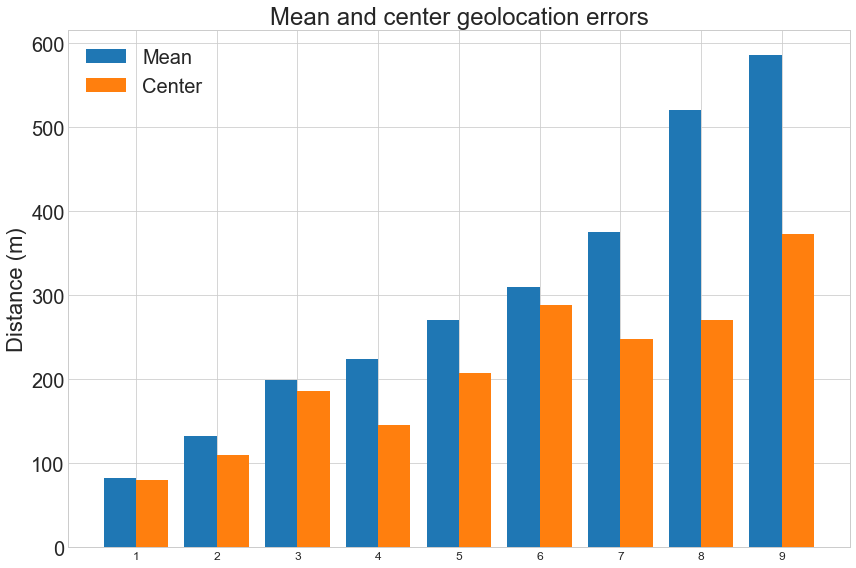

In [41]:
labels = list(map(str,[x for x in range(1,10)]))


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))

center_d = np.round(all_center_dists)
mean_d = np.round(all_mean_dists)

indices = np.argsort(mean_d)
center_d = center_d[indices]
mean_d = mean_d[indices]

rects1 = ax.bar(x - width/2, mean_d, width, label='Mean')
rects2 = ax.bar(x + width/2, center_d, width, label='Center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distance (m)',fontsize=22)
ax.set_title('Mean and center geolocation errors',fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.axis('tight')
plt.tick_params(axis='both', which='minor', labelsize='large')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig.tight_layout()
plt.show()

<Figure size 1440x2016 with 0 Axes>

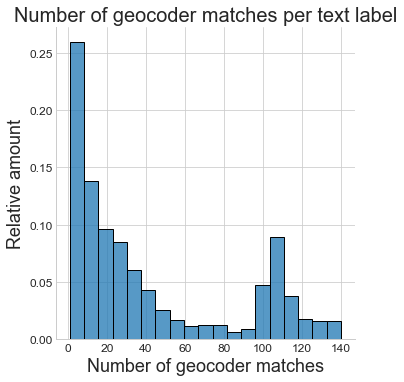

In [45]:
df = pd.DataFrame()
df['g'] = all_len_geos

plt.figure(figsize=(20,28))
sns.displot(df,x='g',stat='probability')
plt.xlabel('Number of geocoder matches',fontsize=18)
plt.ylabel('Relative amount',fontsize=18)
plt.title('Number of geocoder matches per text label',fontsize=20)
plt.axis('tight')
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.show()

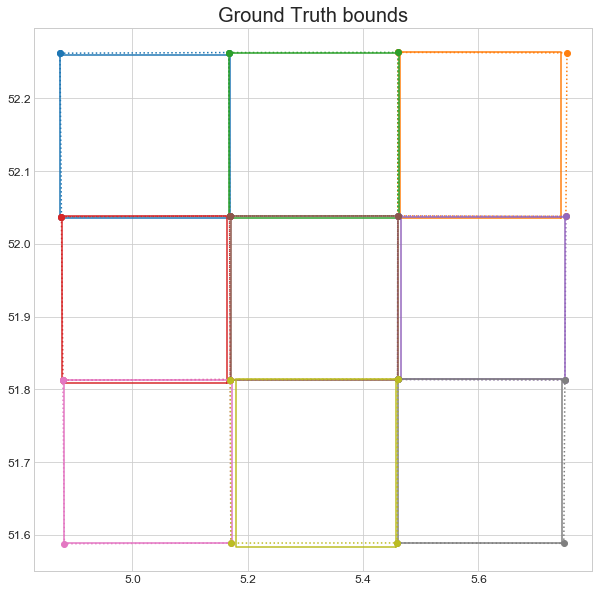

In [46]:
plt.figure(figsize=(10,10))
plt.title('Ground Truth bounds',fontsize=20)
for i in range(len(all_label_polygons)):
    color = 'C'+str(i%10)
    plt.plot(*all_label_polygons[i].exterior.xy,'o:',color=color)
    #plt.plot(*poly_label_bbox.exterior.xy,'--k',color='green')
    plt.plot(*all_bounds[i].exterior.xy,color=color)
    
    
plt.show()